# 0.0 Imports

In [2]:
import re
import datetime
import inflection

import pandas           as pd
import numpy            as np
import seaborn          as sns
import umap.umap_       as umap
import matplotlib.cm    as cm



from IPython.display      import Image
from plotly             import express          as px
from sklearn            import cluster          as ct
from sklearn            import metrics          as mt
from sklearn            import preprocessing    as pp
from matplotlib         import pyplot           as plt
from IPython.display    import HTML
from ydata_profiling    import ProfileReport
from sklearn            import decomposition    as dd
from sklearn.manifold   import TSNE 
from sklearn            import ensemble         as en
from sklearn            import mixture          as mx
from sklearn.neighbors  import NearestNeighbors

from scipy.cluster      import hierarchy        as hc


d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [127]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.2 Load Dataset

In [128]:
df_raw = pd.read_csv('../datasets/data.csv', encoding='ISO-8859-1')

In [129]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 1.0 Descrição dos Dados

In [130]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [131]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [132]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list (map (snakecase, cols_old))

#
df1.columns = cols_new

## 1.2 Data dimensions

In [133]:
print ('Nmber of rows: {}'.format(df1.shape[0]))
print ('Nmber of columns: {}'.format(df1.shape[1]))

Nmber of rows: 541909
Nmber of columns: 8


## 1.3 Data Types

In [134]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA's

In [135]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [136]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [137]:
# create reference

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)
df_backup.head()

#merge original with reference df
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1.sample(20)

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [138]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [139]:
# Remove na
df1 = df1.dropna( subset=['description'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0] / df_raw.shape[0])))


Removed data: 0.00


In [140]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.6 Chance dtypes

In [141]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [142]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%m/%d/%Y %H:%M', errors='coerce')
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'].dt.date)

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


## 1.7 Descriptive Statistics

In [143]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [144]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m= pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


#### 1.7.1.1 Numerical Attributes - Investigating

In [145]:
# Quantity negativa ( pode ser devolução)
# Preço unitario igual a zero ( pode ser promoção?)

### 1.7.2 Categorical Atributes

In [146]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [147]:
# Problema: Invoice a priori deveria ser apenas numeros

# invoice number
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), :]
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2010-12-01,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548


In [148]:
#Explorando as linhas com invoices com letras
#Logo, será assumido que os invoices com letras se tratam de alguma forma de devolução/cancelamento
print('Quantidade de invoices que possui letras: {}'.format(len (df_letter_invoices)))
print('Quantidade de invoices que possui letras e com quantity menor que 0: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Quantidade de invoices que possui letras: 9291
Quantidade de invoices que possui letras e com quantity menor que 0: 9288


In [149]:
# stock code

#Check stock code with characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# Ação:
# Remover stock_code in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [150]:
# description

# Ação:
# Remover descrição

In [151]:
# country

len(df1['country'].unique())

38

In [152]:
df1['country'].value_counts(normalize = True)

country
United Kingdom          0.914089
Germany                 0.017569
France                  0.015833
EIRE                    0.015165
Spain                   0.004687
Netherlands             0.004387
Belgium                 0.003828
Switzerland             0.003704
Portugal                0.002811
Australia               0.002330
Norway                  0.002009
Italy                   0.001486
Channel Islands         0.001403
Finland                 0.001286
Cyprus                  0.001151
Sweden                  0.000855
Unspecified             0.000825
Austria                 0.000742
Denmark                 0.000720
Japan                   0.000662
Poland                  0.000631
Israel                  0.000550
USA                     0.000538
Hong Kong               0.000533
Singapore               0.000424
Iceland                 0.000337
Canada                  0.000279
Greece                  0.000270
Malta                   0.000235
United Arab Emirates    0.000126
Eu

In [153]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Filtragem de Variáveis

In [30]:
df2 = df1.copy()

In [31]:
# ----- Numerical Attributes ----
# unit prince > 0.0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# --------- Categorical Attributes -------
# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#description
df2 = df2.drop( columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]


# ----- Numerical Attributes ----
# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]



# 3.0 Feature Engineering

In [32]:
# Features Ideias:
# Moving Average - 7d, 14d, 30d
# Quantidade de Compras por mes, antes do dia 15 e depois do dia 15
# Average Financial
# Basket Size * Price - Quantidade de preços por cesta


In [33]:
df3 = df2.copy()

## 3.1 Feature Creation

In [34]:
# data reference 

df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity',
                    'invoice_date', 'unit_price', 'country'] , axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [35]:
# Gross Revenue (Faturamento) quantity * price = Faturamente

df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary 

df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()


C:\Users\Ian\AppData\Local\Temp\ipykernel_11584\332750283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency (Day from last purchase)

In [36]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity purchases

In [37]:
# Quantidade de compras
df_freq = (df2_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                     .groupby('customer_id')
                                                     .count()
                                                     .reset_index()
                                                     .rename( columns={'invoice_no': 'qtd_invoices'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
dtype: int64

### 3.1.4 Quantity of items purchased

In [38]:
# Quantidade de items
df_freq = (df2_purchase[['customer_id', 'quantity']].groupby('customer_id')
                                                    .sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity': 'qtd_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
dtype: int64

### 3.1.5 Quantity of products purchased

In [39]:
# Quantidade de Produtos
df_freq = (df2_purchase[['customer_id', 'stock_code']].groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename(columns={'stock_code': 'qtd_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
dtype: int64

### 3.1.5 Avg Ticket

In [40]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2)
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
avg_ticket       91
dtype: int64

### 3.1.6 Avg Recency Day

In [41]:
# Avg recency Days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False,False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #next customer
df_aux['previous_invoice_date'] = df_aux['invoice_date'].shift() #next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ((x['invoice_date'] - x['previous_invoice_date']).days)*-1 if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)


df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_invoice_date'], axis=1).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [42]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                   .groupby('customer_id')
                                                   .agg ( max_ = ('invoice_date', 'max'),
                                                          min_ = ('invoice_date', 'min'),
                                                          days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                          buy_ = ('invoice_no', 'count')                                                      
                                                   )).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [43]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_returns'})
df_returns['qtd_returns'] = df_returns['qtd_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtd_returns            0
dtype: int64

### 3.1.9 Basket Size - Quantidade de items por cesta (quantity)
- Invoice No = Compra = Purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [44]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id'])
                                                                          .agg( n_purchase = ('invoice_no', 'nunique'),
                                                                                n_products = ('quantity', 'sum'))
                                                                          .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']


# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtd_returns            0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size - Quantidade de produtos distindos por compra

In [45]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id'])
                                                                          .agg( n_purchase = ('invoice_no', 'nunique'),
                                                                                n_products = ('stock_code', 'nunique'))
                                                                          .reset_index())
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtd_invoices                91
qtd_items                   91
qtd_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA (Exploratory Data Analysis)

In [46]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_invoices              0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Notes**
1. Cluster Coesos - Separados
2. Métricas
    - Min, Max, Range (Dispersão)
    - Média, Mediana
    - Desvio padrão e a Variância
    - Coeficiente de Variação (std/media)
    - Distribuição.


In [47]:
# profile = ProfileReport(df4)
# profile.to_file('output_v3.html')

### 4.1.1 Gross Revenue

In [48]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.50,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.45,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.30,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.76,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.70,20.866667,0.063694,427.0,3868.650000,22.150000


### 4.1.2 Qtd Items

In [49]:
df3[df3['customer_id'] == 14646].head(30)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2010-12-20,0.29,Netherlands,14646
37953,539491,21986,12,2010-12-20,0.29,Netherlands,14646
37954,539491,22720,2,2010-12-20,4.95,Netherlands,14646
37955,539491,21931,1,2010-12-20,1.95,Netherlands,14646
37956,539491,22613,2,2010-12-20,0.85,Netherlands,14646
37957,539491,20751,1,2010-12-20,2.10,Netherlands,14646
37958,539491,21246,2,2010-12-20,4.95,Netherlands,14646
37959,539491,22960,1,2010-12-20,4.25,Netherlands,14646
37960,539491,22355,2,2010-12-20,0.85,Netherlands,14646
37961,539491,21123,2,2010-12-20,1.25,Netherlands,14646


In [50]:
df4[df4['qtd_products'] == 7838]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.23,3.321429,0.33244,203.0,185.91129,10.66129


### 4.1.3 Avg Ticket

In [51]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size


In [52]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.4 Frequency

In [53]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtd_invoices',
       'qtd_items', 'qtd_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtd_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [54]:
df4[df4['frequency'] == 17] 

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.5,17.0,40.0,50.970588,0.617647


In [55]:
df3[df3['customer_id'] == 17850].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850


### 4.1.5 Avg Basket Size

In [56]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size


In [57]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


## 4.2 Bivariate Analysis

In [58]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1)

<Figure size 2500x1200 with 0 Axes>

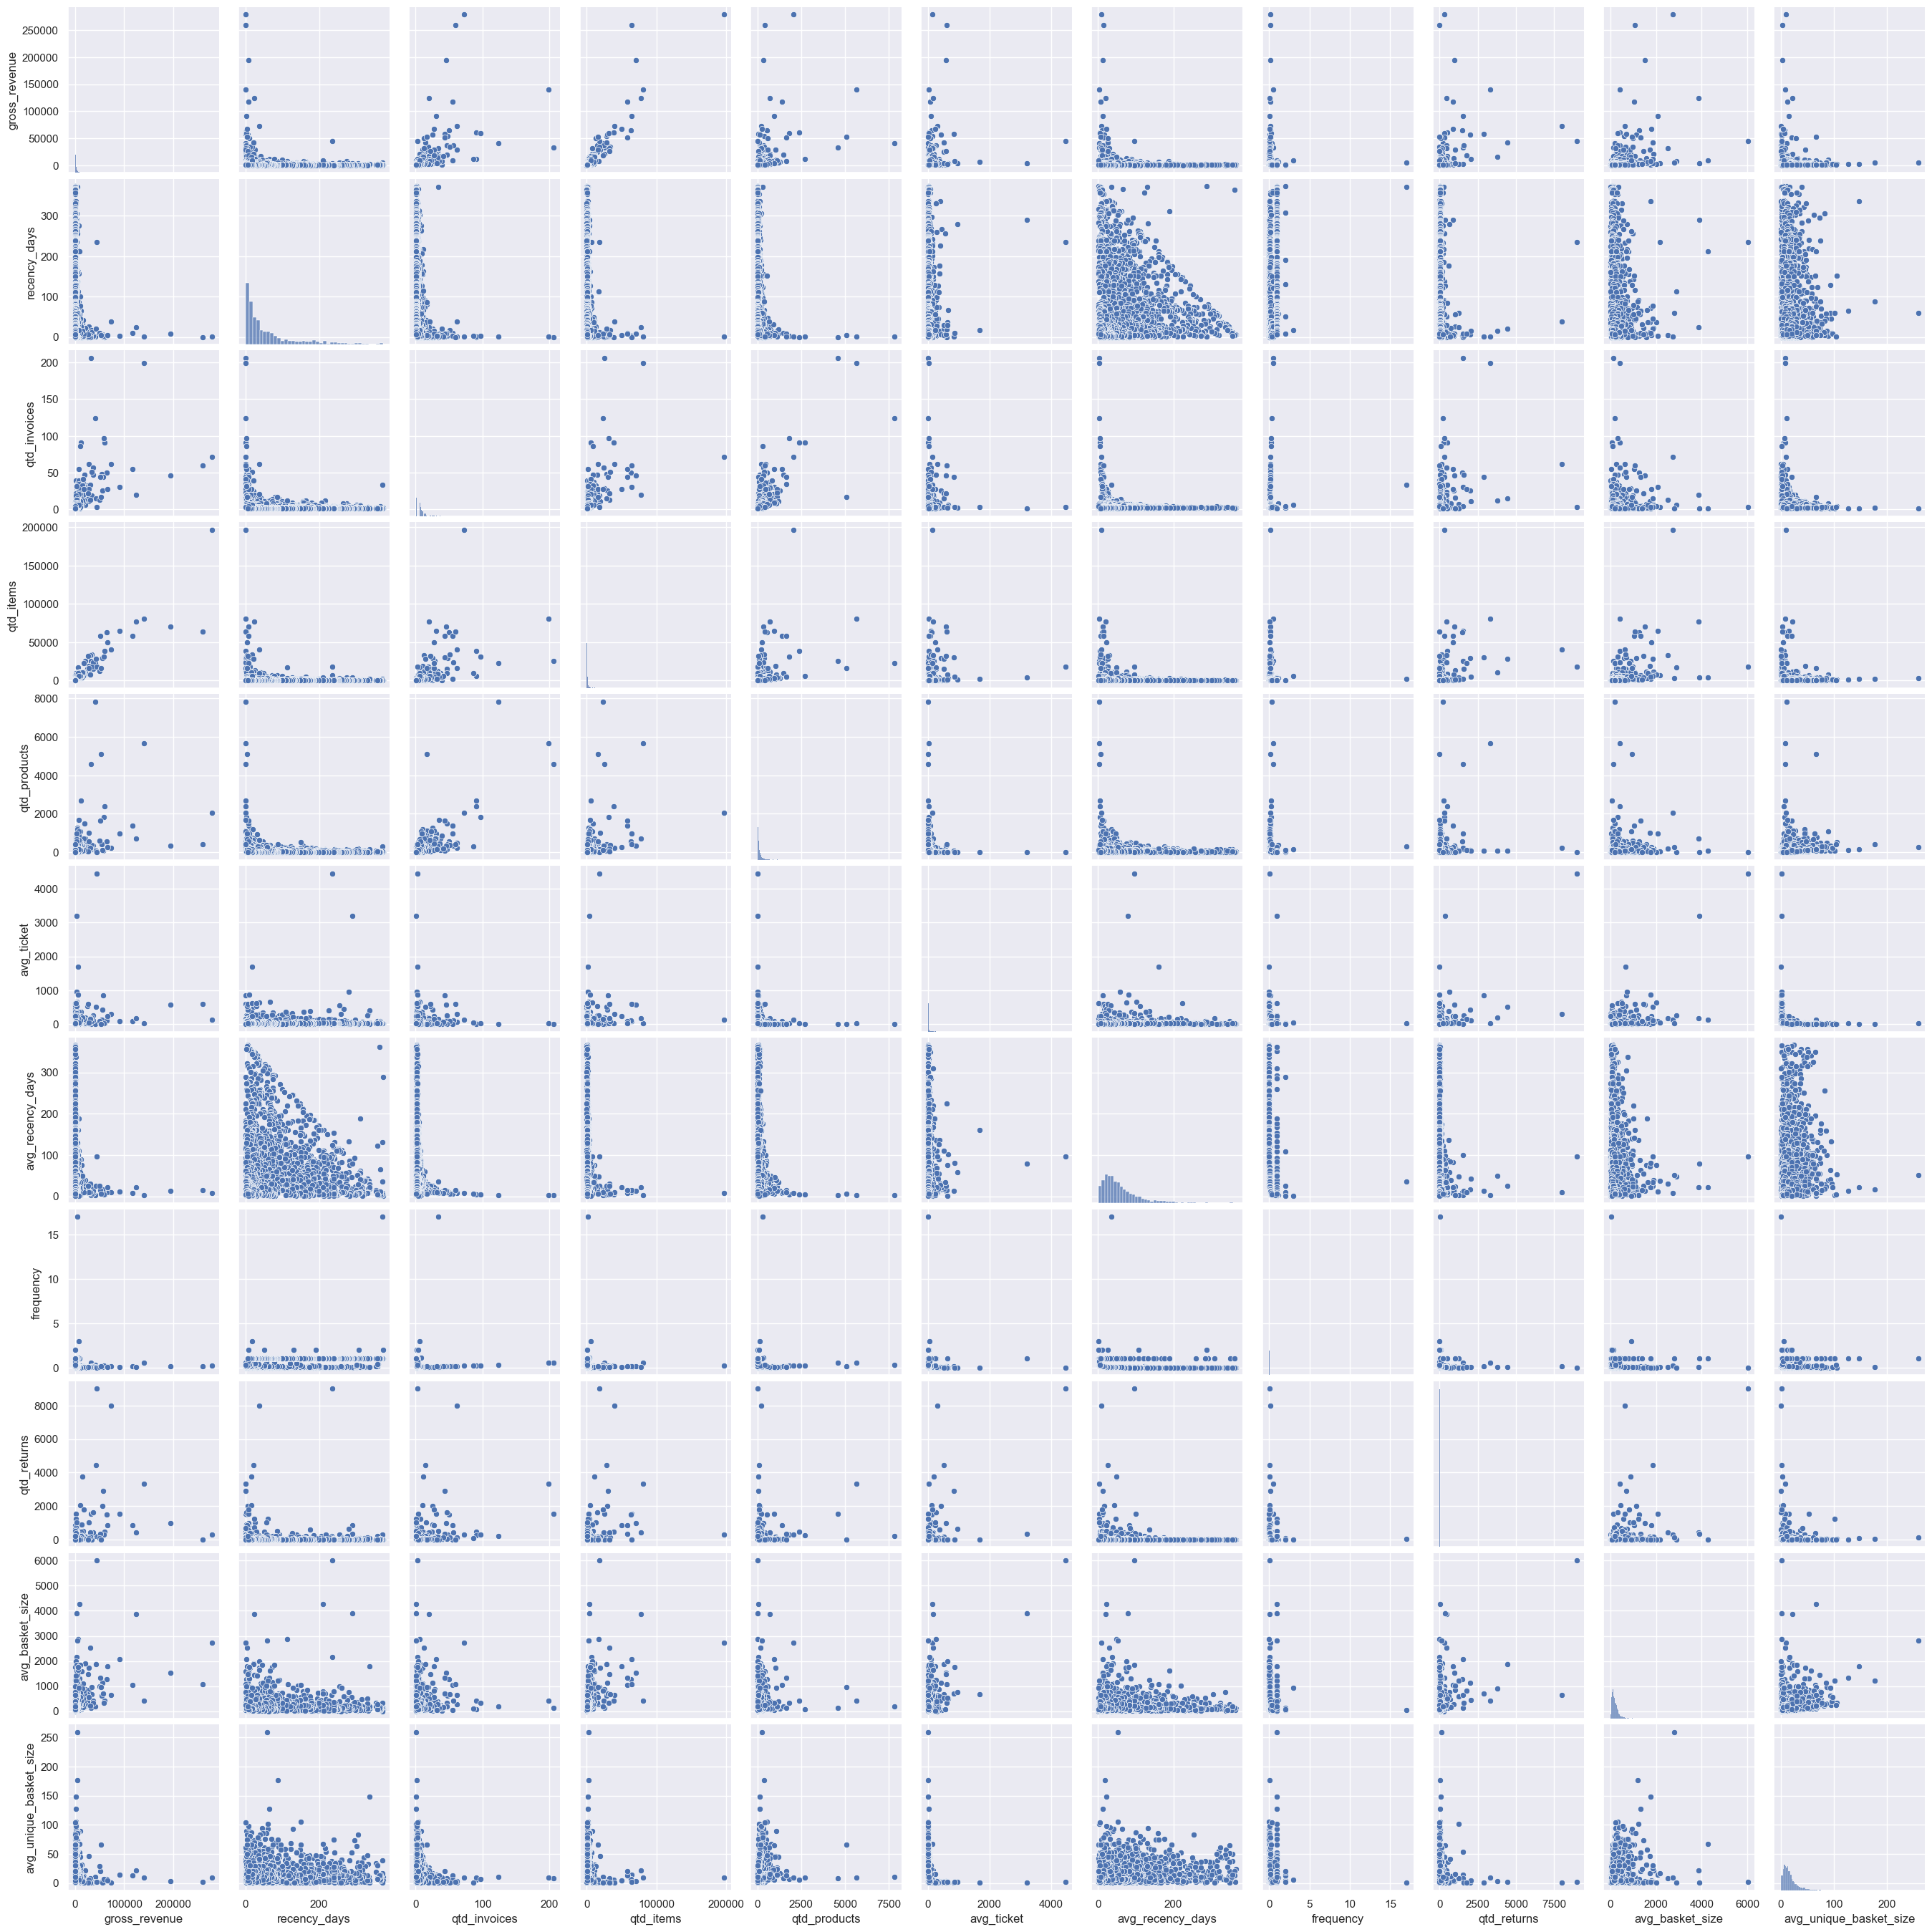

In [59]:
plt.figure (figsize=(25,12))
sns.pairplot(df42)

**Notes**
1. Frequency has low variance
2. Avg ticket has low variance

## 4.3 Estudo do Espaço

In [60]:
# original dataset

#df43 = df4.drop( columns=['customer_id'], axis=1).copy()

# selected dataset
cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'qtd_returns']
df43 = df4[cols_select].copy()

In [61]:
# original dataset hipotesis
# mm = pp.MinMaxScaler()


# df43['gross_revenue']           = mm.fit_transform(df43[['gross_revenue']])
# df43['recency_days']            = mm.fit_transform(df43[['recency_days']])
# df43['qtd_invoices']            = mm.fit_transform(df43[['qtd_invoices']])
# df43['qtd_items']               = mm.fit_transform(df43[['qtd_items']])
# df43['qtd_products']            = mm.fit_transform(df43[['qtd_products']])
# df43['avg_ticket']              = mm.fit_transform(df43[['avg_ticket']])
# df43['avg_recency_days']        = mm.fit_transform(df43[['avg_recency_days']])
# df43['frequency']               = mm.fit_transform(df43[['frequency']])
# df43['qtd_returns']             = mm.fit_transform(df43[['qtd_returns']])
# df43['avg_basket_size']         = mm.fit_transform(df43[['avg_basket_size']])
# df43['avg_unique_basket_size']  = mm.fit_transform(df43[['avg_unique_basket_size']])

# X = df43.copy()


In [62]:
# selected dataset

mm = pp.MinMaxScaler()
df43['gross_revenue']           = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']            = mm.fit_transform(df43[['recency_days']])
df43['qtd_products']            = mm.fit_transform(df43[['qtd_products']])
df43['frequency']               = mm.fit_transform(df43[['frequency']])
df43['qtd_returns']             = mm.fit_transform(df43[['qtd_returns']])

X = df43.copy()


### 4.3.1 PCA

In [63]:
X.shape[1]

6

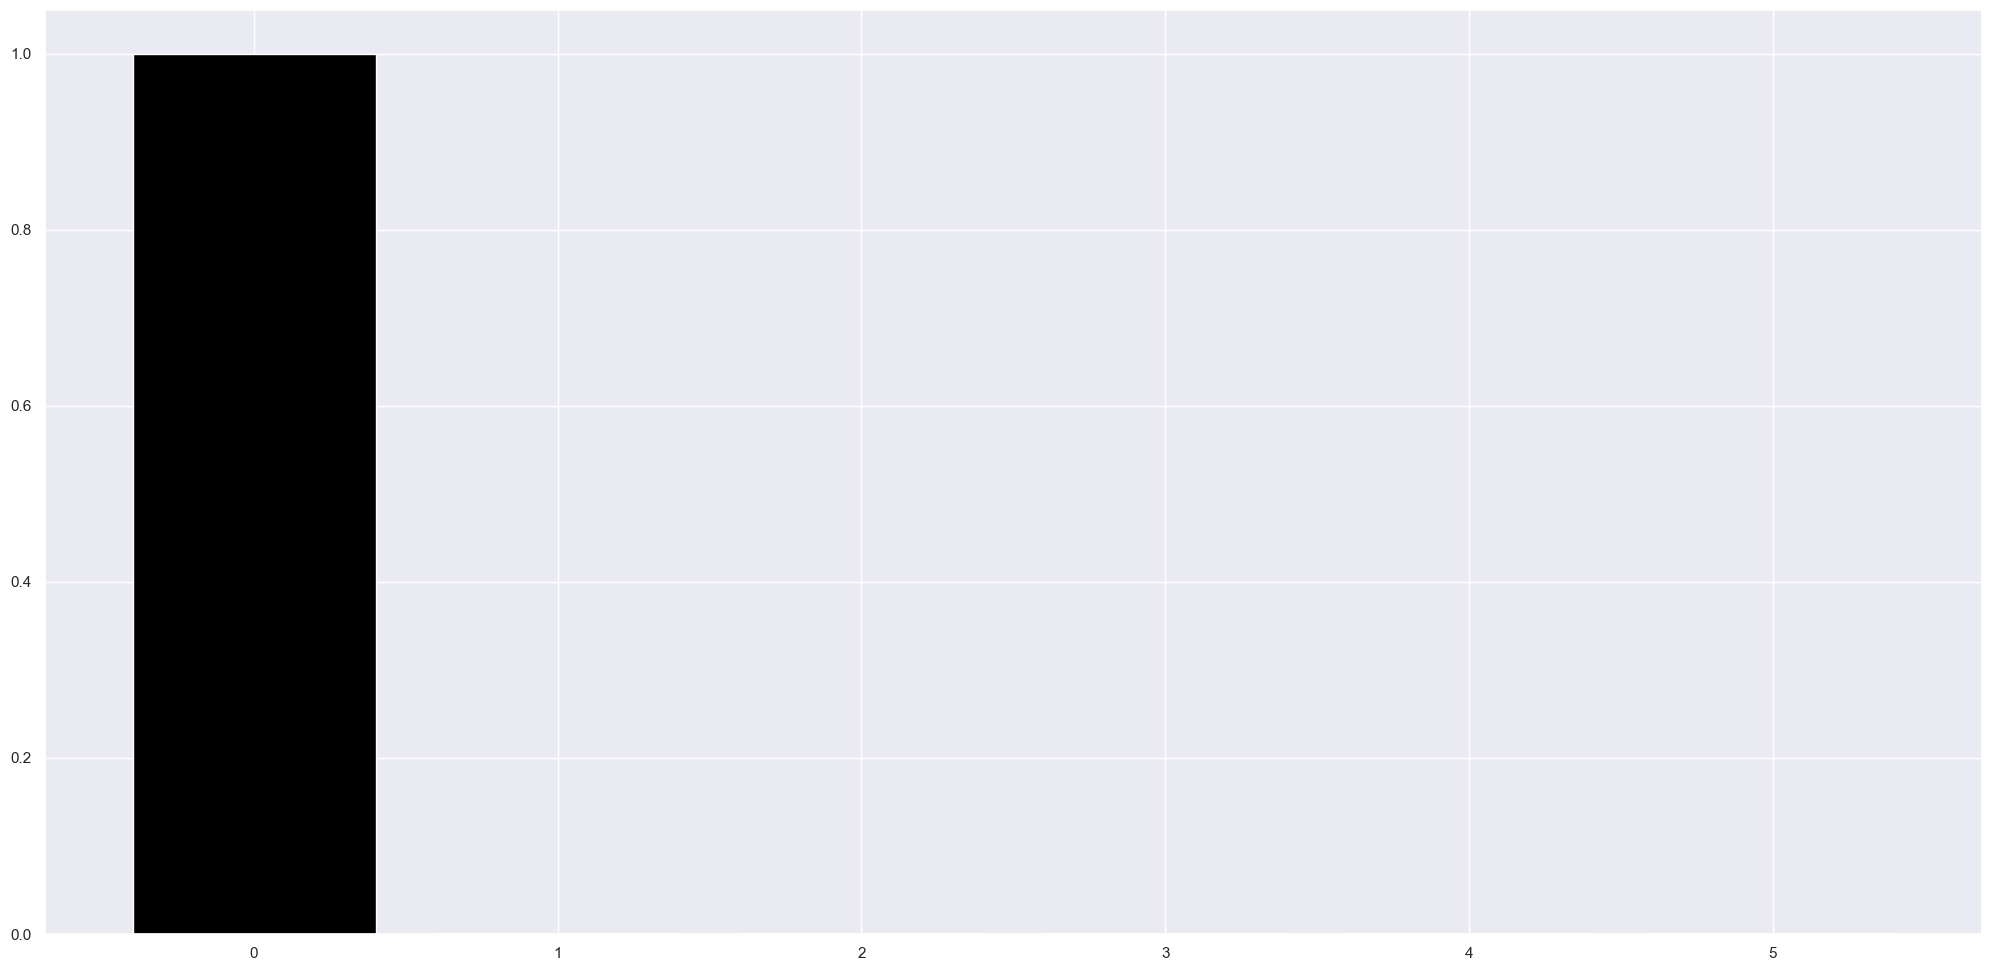

In [64]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_,color='black')

# pca component

df_pca = pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

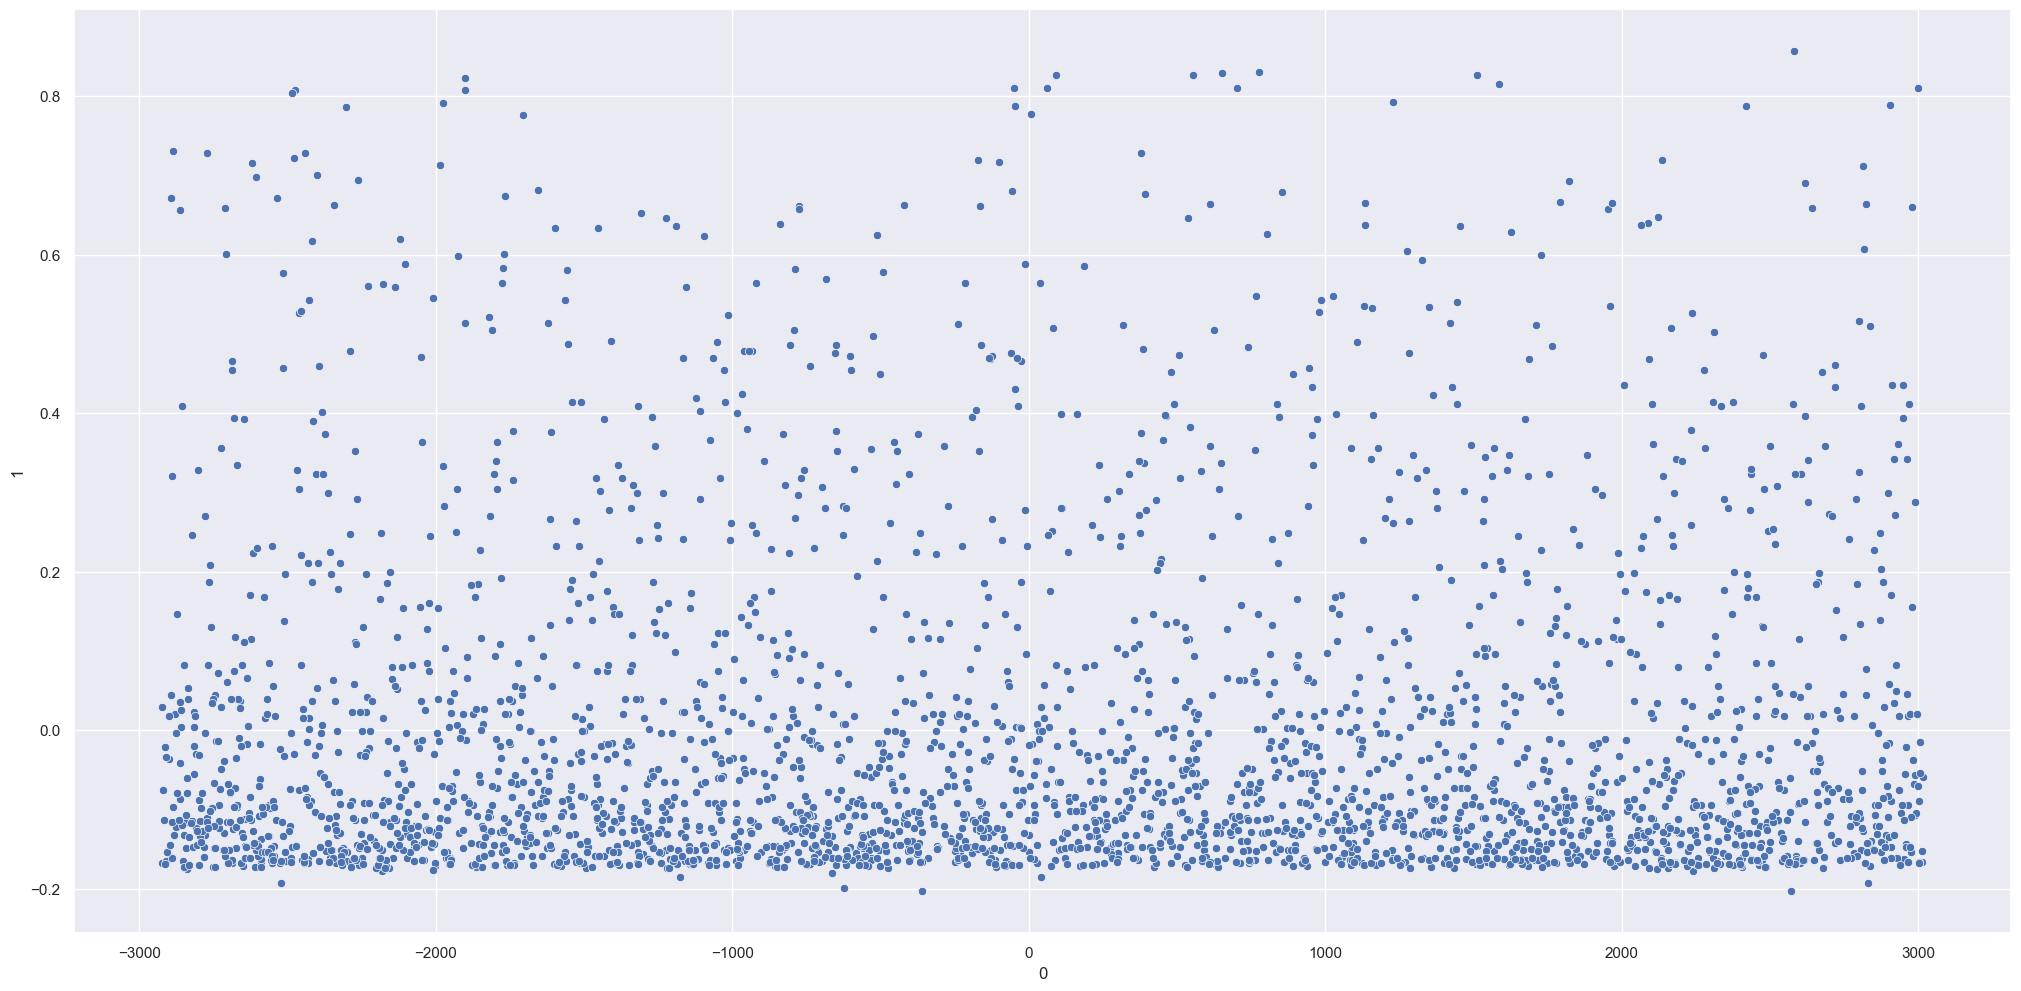

In [65]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 UMAP

d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

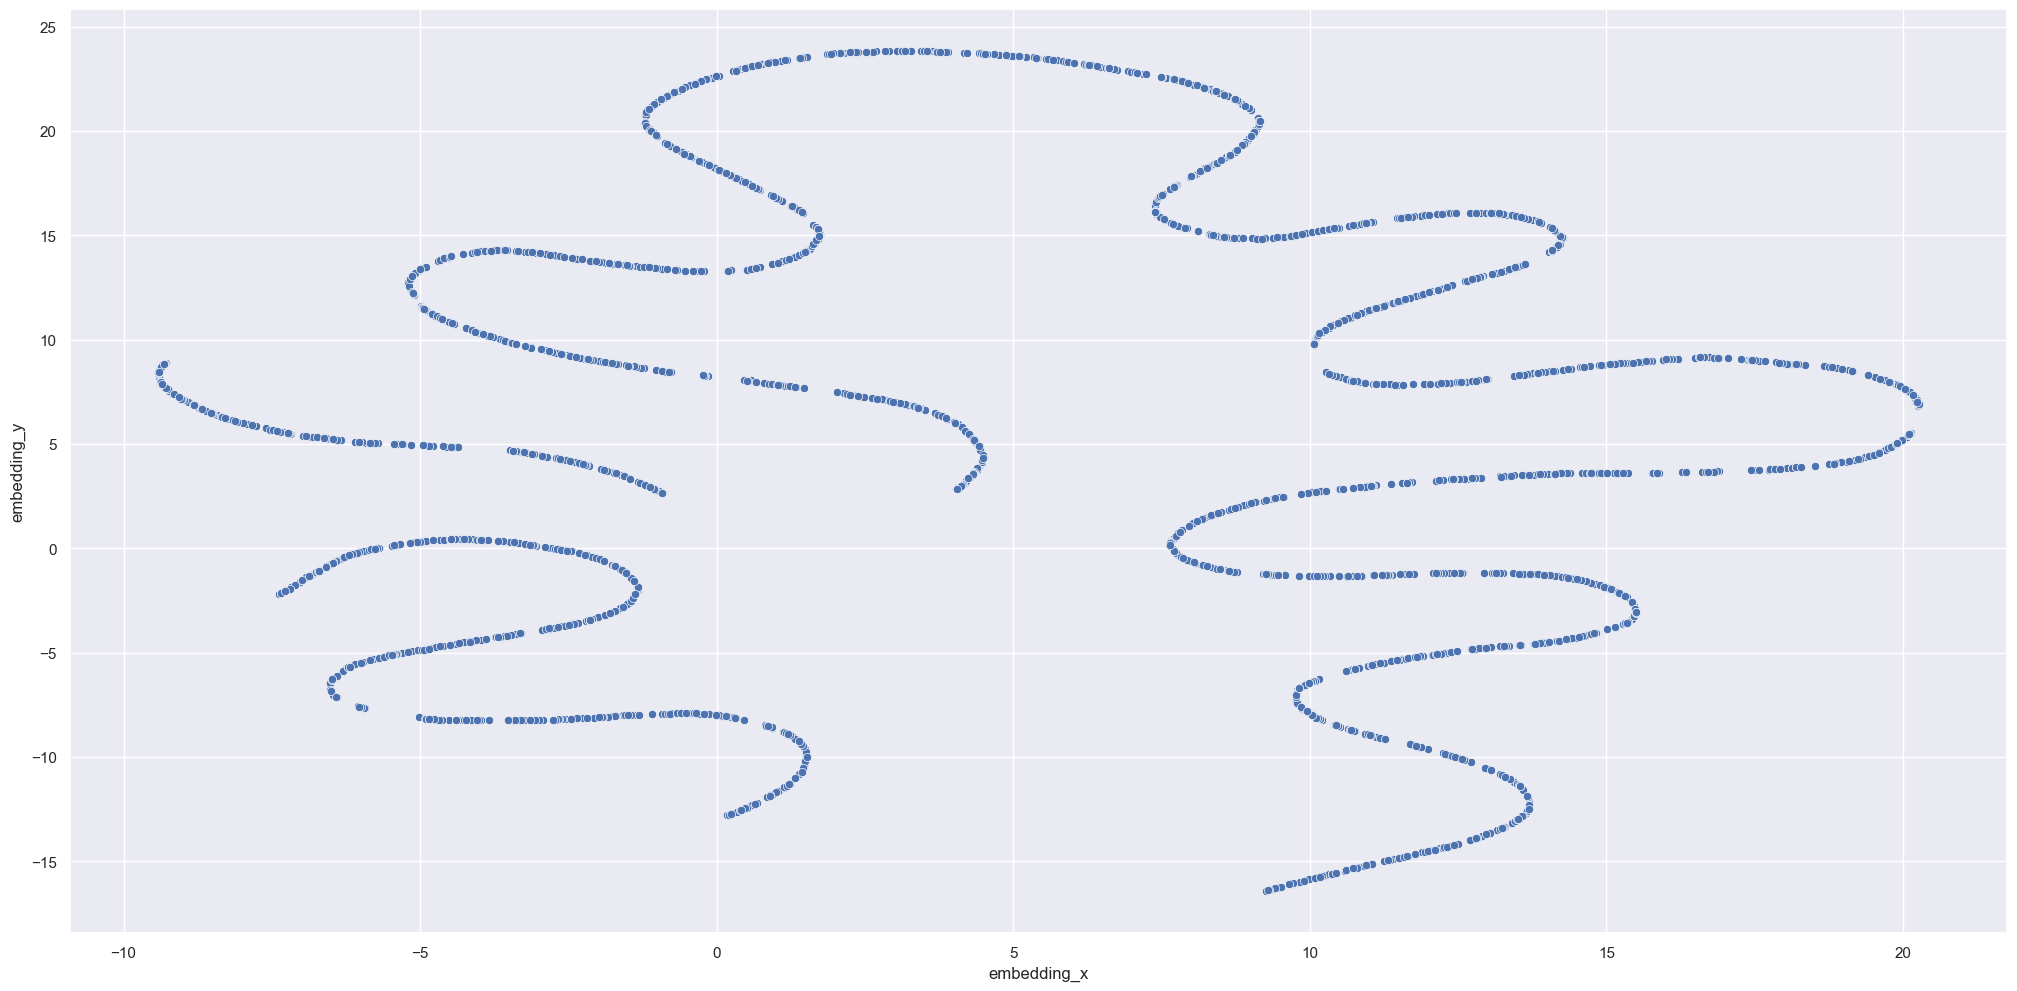

In [66]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot (x='embedding_x', y='embedding_y',
                 data=df_pca)

### 4.3.3 t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

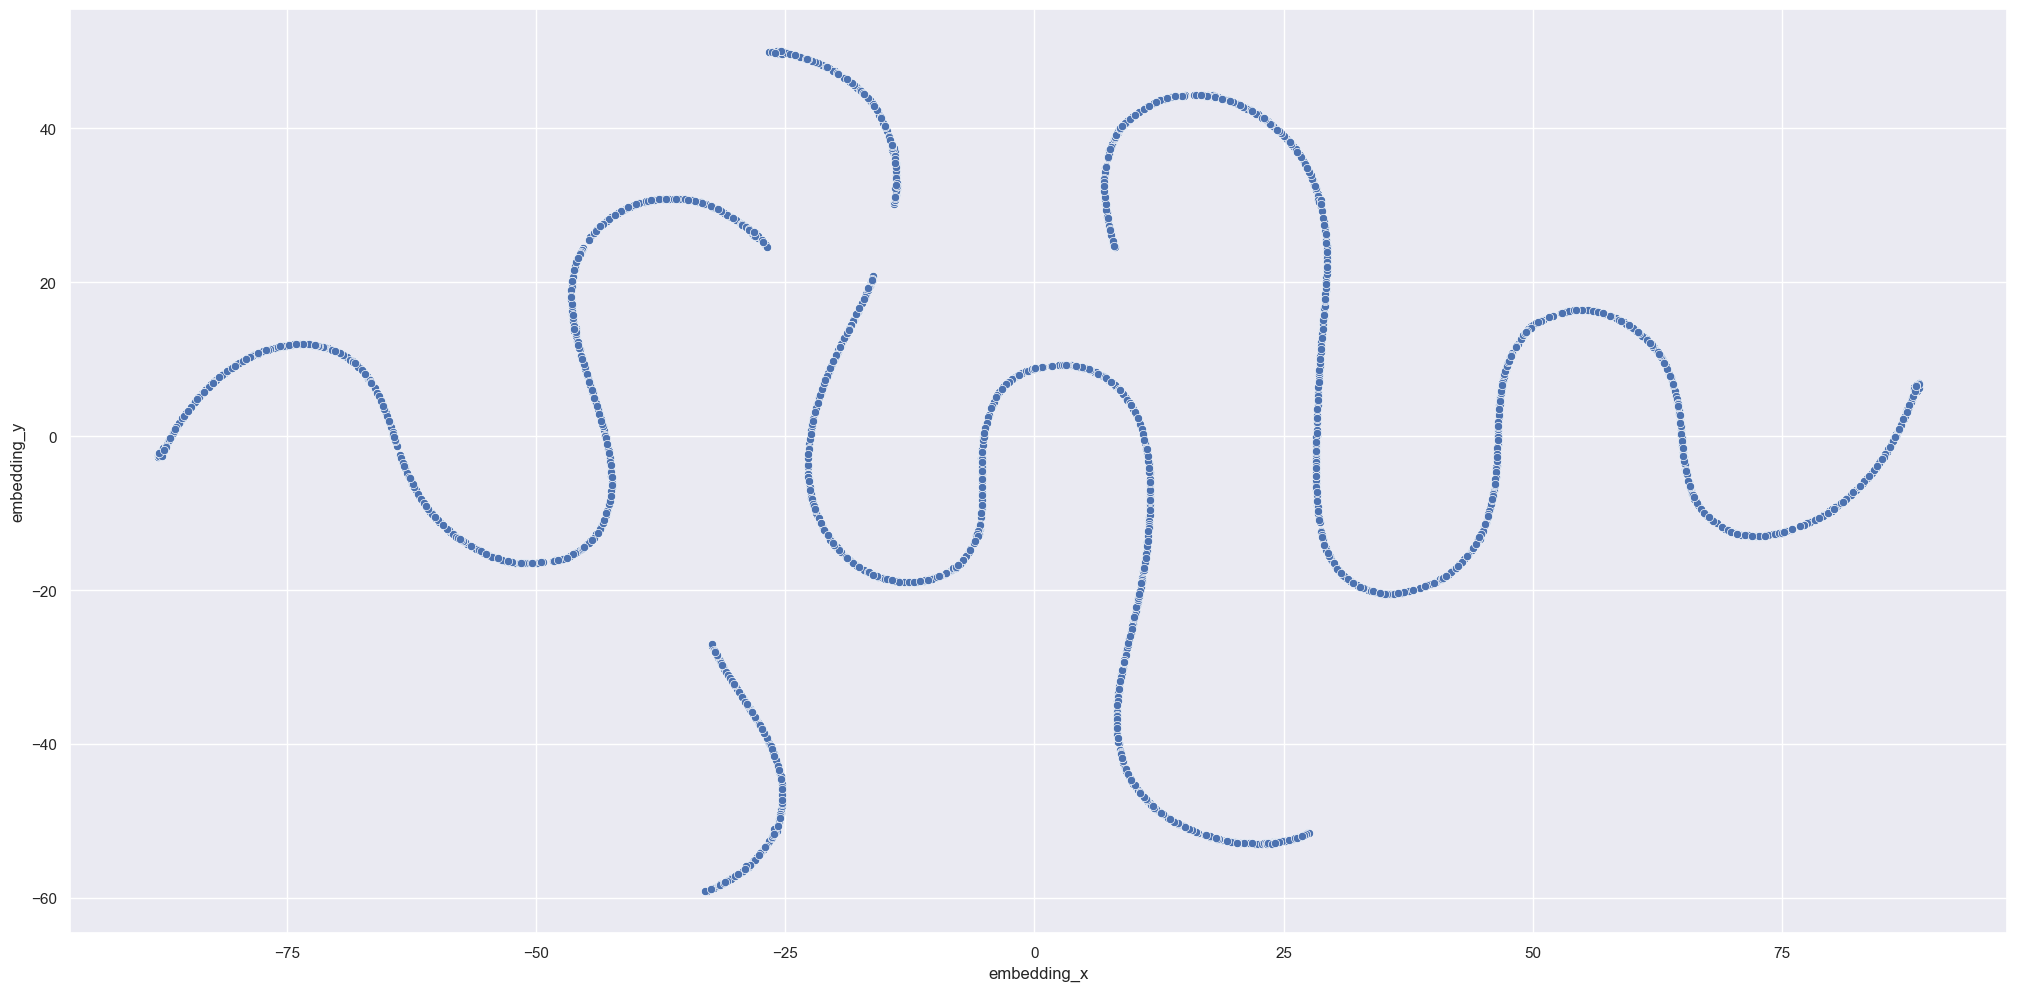

In [67]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot (x='embedding_x', y='embedding_y',
                 data=df_pca)

### 4.3.4 Tree-Based Embedding


In [68]:
# training dataset

X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training

rf_model.fit(X, y)

# Leaf

df_leaf = pd.DataFrame(rf_model.apply(X))

# dataframe Leaf

In [69]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,3177,3326,3337,2285,3147,3252,3130,3175,3363,3155,3306,3146,3189,2800,3205,3010,3174,3102,3265,3066,3081,2905,3299,3349,3362,3270,3015,3089,3041,3311,3384,3374,3336,3144,3248,3409,3123,2961,3029,3278,3248,3220,3134,3180,3143,3287,3338,3348,3137,3109,2920,3084,3391,3376,3219,3169,3360,3220,2977,3422,2885,3336,3252,2713,3042,3301,3327,3131,3305,3344,3271,2702,2967,3115,3159,2965,3105,3217,3048,3236,3323,3137,3072,3290,3098,3288,3195,3133,3272,3187,3178,3176,3059,3044,3117,3187,2826,3356,3293
1,2961,2924,3042,2970,2738,3131,2924,2830,3110,2853,3101,2564,2550,3115,2749,3123,2984,3045,3064,2755,2954,3020,2734,2833,3013,2918,2840,2780,3084,3032,2869,3018,2969,2746,2919,2972,2854,2665,3055,3019,2972,2783,3192,3109,3124,2761,2912,2933,2980,3107,3175,3006,3057,2950,2979,2961,3128,3018,2861,2962,2994,2859,2897,2866,2999,3038,2978,2904,3042,2916,2957,2972,3147,2927,3042,2786,2901,3070,3160,3024,2919,2891,2983,2586,2909,3089,2940,3152,3092,2852,2509,2885,2883,2993,3146,3010,2911,2799,2965,2824
2,3633,3607,3587,3411,3570,3660,3631,3548,3684,3615,3628,3579,3545,3653,3566,3567,3583,3654,3552,3467,3512,3638,3604,3522,3571,3645,3576,3603,3587,3719,3431,3673,3595,3634,3574,3614,3544,3521,3597,3483,3653,3403,3634,3508,3535,3600,3424,3649,3633,3550,3631,3503,3570,3607,3683,3629,3610,3644,3571,3568,3615,3588,3582,3689,3456,3623,3651,3494,3553,3623,3587,3427,3574,3612,3544,3557,3599,3563,3540,3494,3436,3449,3571,3427,3531,3597,3583,3707,3587,3563,3600,3440,3561,3483,3602,3457,3526,3620,3568,3644
3,1278,1412,1758,1489,2018,1461,2113,1458,1655,1717,2045,2298,1344,1603,1523,1998,1921,1601,1932,1412,1829,1442,1464,1495,1145,1475,1509,1527,1986,1307,1944,1533,1505,1450,1539,1536,2158,2205,1660,1483,1495,1482,1462,1808,1530,1495,1465,1432,1373,1664,1808,1493,1349,2227,2107,1492,1556,1738,1298,2125,1483,1903,1887,1773,1485,1490,1392,1758,1064,1361,2301,1587,2183,2172,1272,2050,2044,1499,1917,1474,1911,1419,1520,1651,1481,1489,2055,1341,1661,1541,1877,1722,2027,1886,1923,2266,1470,1196,1987,2106
4,355,715,580,691,146,711,734,691,191,197,580,722,665,195,569,612,575,418,549,391,577,709,416,200,629,210,440,206,147,729,703,201,211,202,233,718,595,203,702,973,516,876,217,591,890,676,285,604,690,607,588,184,756,401,80,549,700,665,720,604,231,731,188,206,667,454,474,592,456,202,713,229,549,620,712,199,718,180,108,226,213,696,757,217,682,162,305,725,686,808,331,192,584,544,196,156,189,705,706,175


d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

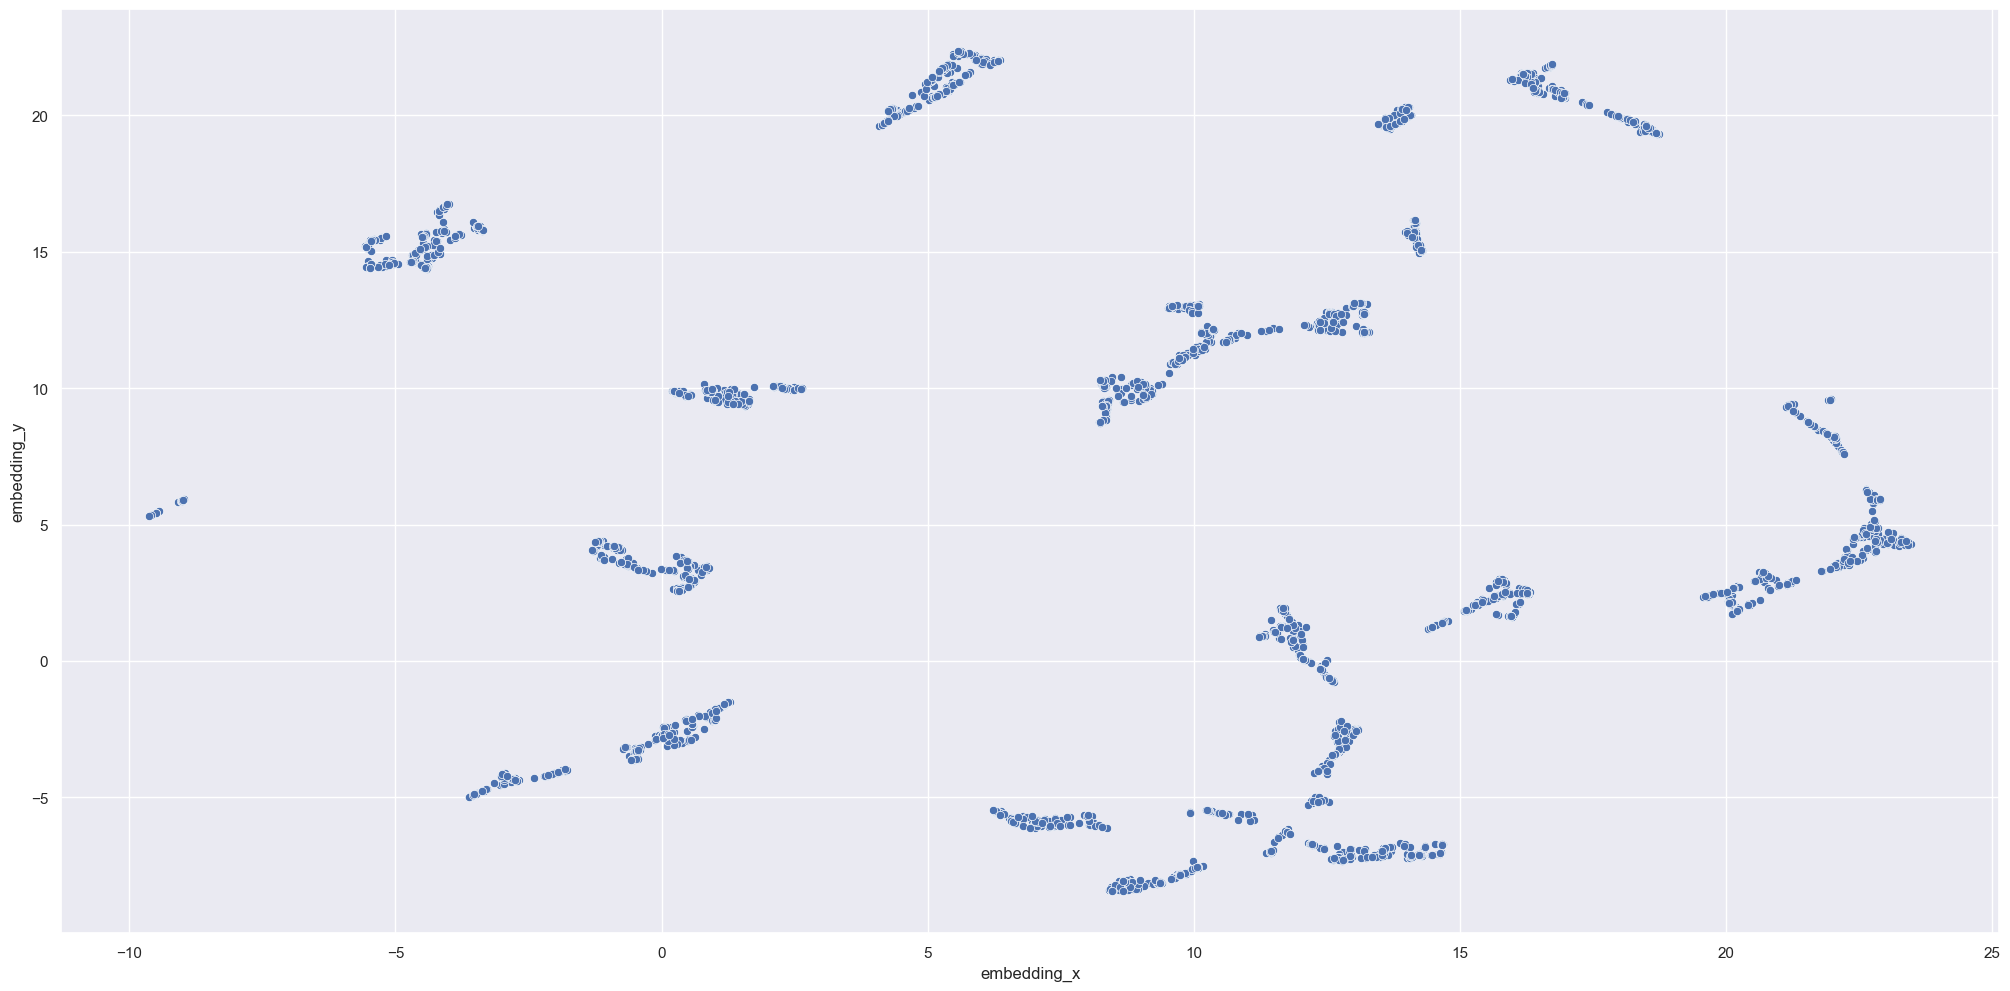

In [70]:
# Reduzir a dimensionalidade
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot (x='embedding_x', y='embedding_y',
                 data=df_tree)

# 5.0 Data Preparation

- Padronização -> PRemissa de que os dados vieram de uma distribuição normal
- Rescale -> Não premissa de que os dados vieram de uma distribuição normal

**Rules Checklist**
1. Distribuição Normal e não possui Outlier -> Standart Scaler - Media e desvio padrao
2. Distribuição Normal e possui Outlier -> Robust Scaler - Quartis
3. Distribuição não-Normal -> Min Max Scaler 


**Testes de Normalidade**
- QQ Plot -> Quantile Quantile Plot ( Quantile teorica x Quantile real)
- KS Test -> Kolgomorov Smirnoff (Teste de Hipótese) Se p-value > 0.5 = Distribuição normal, Else não é uma distribuição normal

**Detecção de Outilers**
- Box Plot -> Pontos são identificados como Outliers
- IRQ * 2.5 -> Acima desse valor (Outlier)
- Z-Score -> Maior que 3 Outilier. Menor que 3 Outilier

In [71]:
#df5 = df4.copy()
#df5_aux = df4.copy()

df5 = df_tree.copy()

In [72]:
# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

# df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])

# df5['recency_days'] = mm.fit_transform(df5[['recency_days']])

# #df5['qtd_invoices'] = mm.fit_transform(df5[['qtd_invoices']])

# #df5['qtd_items'] = mm.fit_transform(df5[['qtd_items']])

# df5['qtd_products'] = mm.fit_transform(df5[['qtd_products']])

# #df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])

# #df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']])

# df5['frequency'] = mm.fit_transform(df5[['frequency']])

# df5['qtd_returns'] = mm.fit_transform(df5[['qtd_returns']])

# #df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])

# #df5['avg_unique_basket_size'] = mm.fit_transform(df5[['avg_unique_basket_size']])

# variable = 'qtd_products'


# 6.0 Feature Selection

In [73]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'qtd_returns']

In [72]:
#df6 = df5[cols_select].copy()
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tuning

In [73]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [74]:
X.head()

,embedding_x,embedding_y
0,2.488963,10.027324
1,-5.536704,15.134569
2,-1.865603,-4.041065
3,21.166323,9.363273
4,11.099811,-5.629389


In [75]:
#clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2,25,1)

## 7.1 Models

### 7.1.1 K-Means

In [77]:
kmeans_list = []
for k in clusters:
    # model
    kmeans_model = ct.KMeans(n_clusters=k)

    # training

    labels = kmeans_model.fit_predict(X)

    # performace

    kmeans_list.append(mt.silhouette_score(X, labels, metric='euclidean'))

Text(0.5, 1.0, 'Silhouette Score x K')

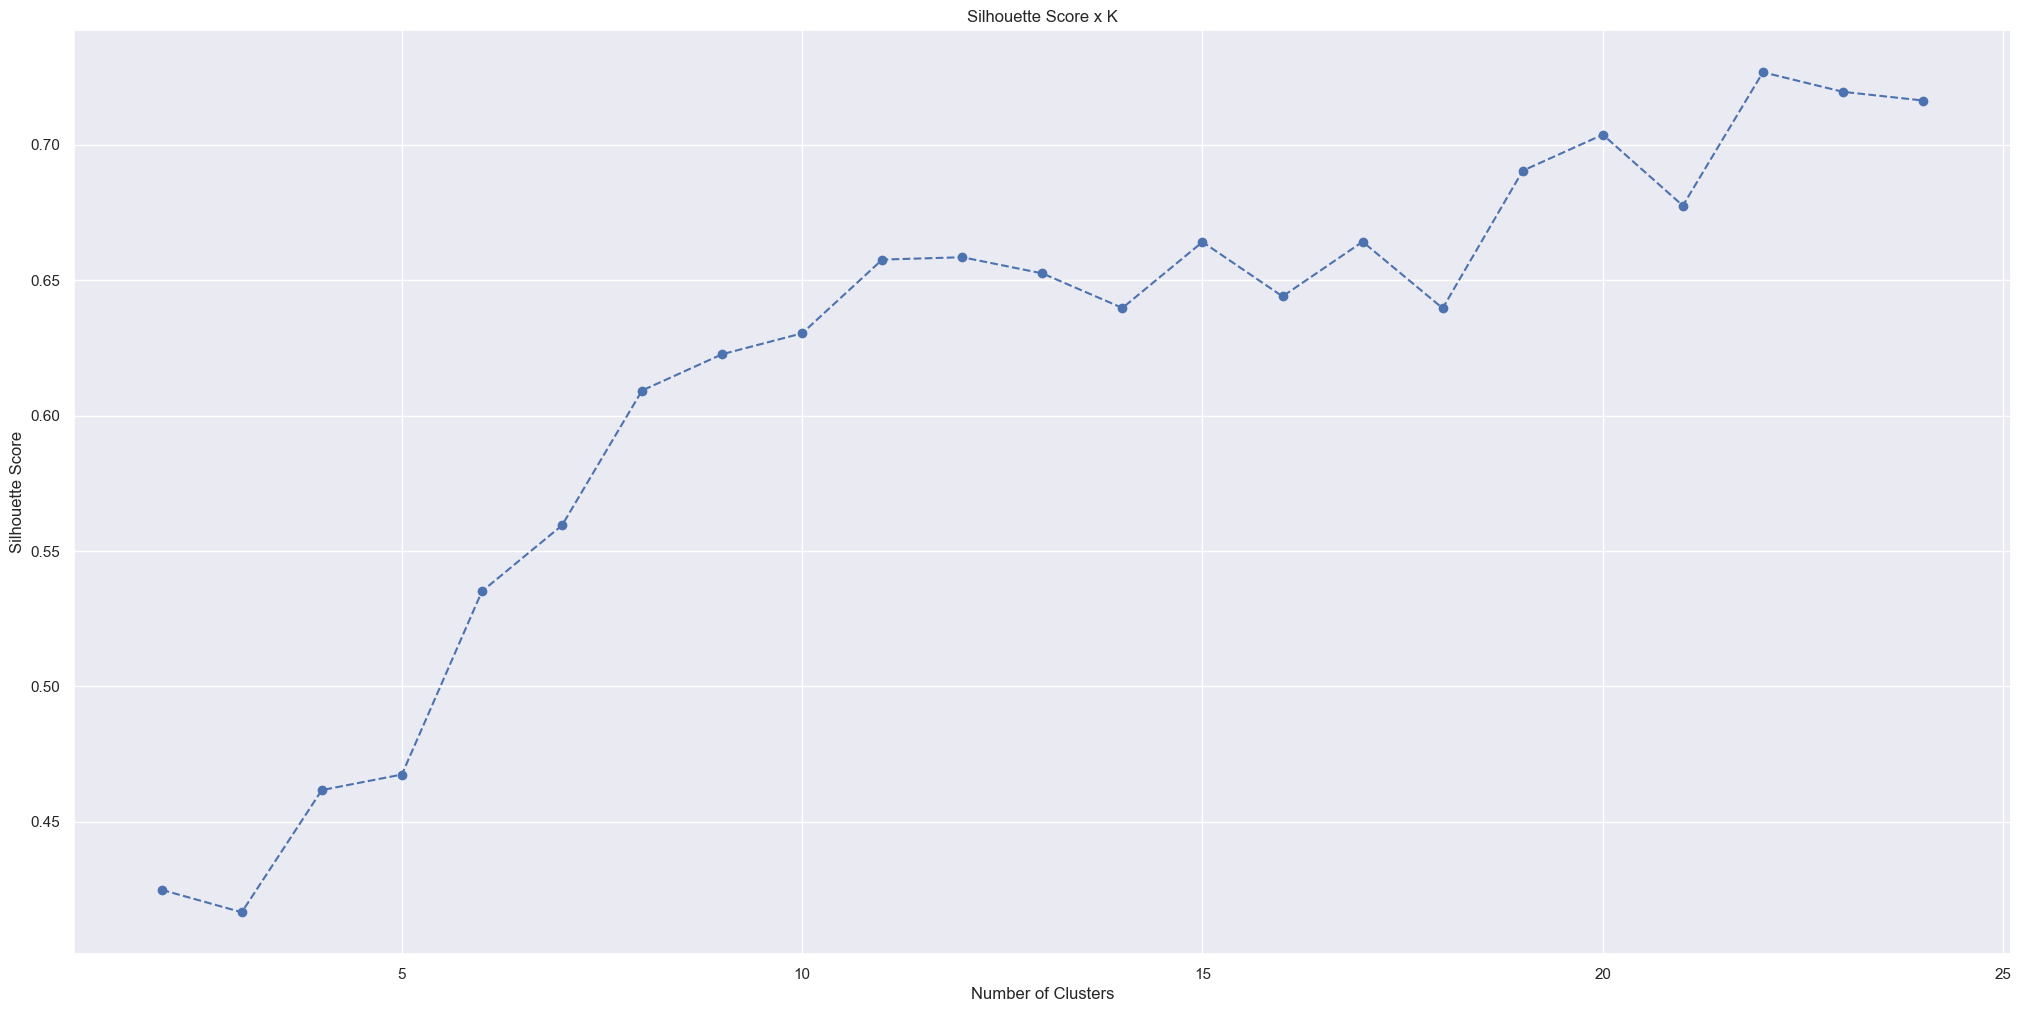

In [78]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### 7.1.2 Gaussian Mixture Model

In [79]:
gmm_list = []
for k in clusters:
    # definition

    gmm_model = mx.GaussianMixture(n_components=k)

    # training

    labels = gmm_model.fit_predict(X)

    # performace

    gmm_list.append(mt.silhouette_score(X, labels, metric='euclidean'))

Text(0.5, 1.0, 'Silhouette Score x K')

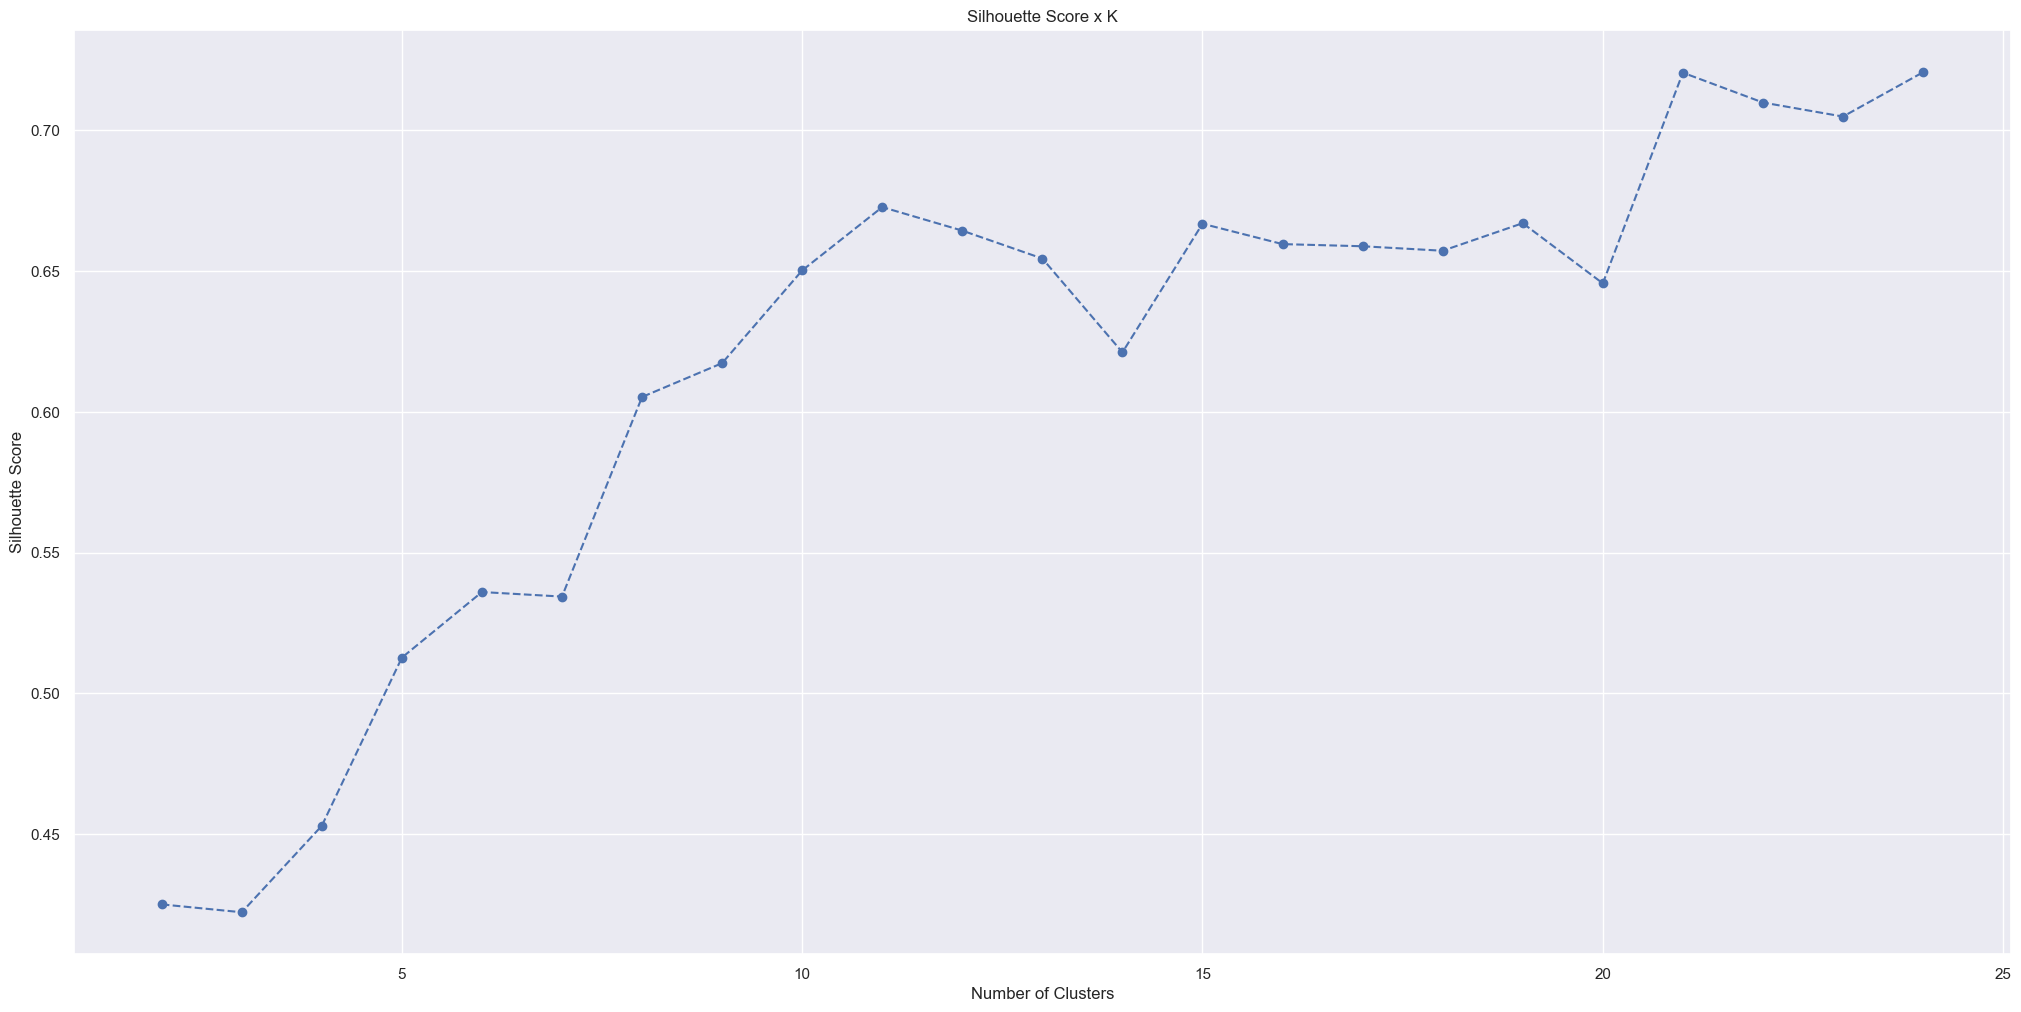

In [80]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### 7.1.3 Hierarchichal Clustering

In [81]:
# definition

hc_model = hc.linkage(X, 'ward')

[]

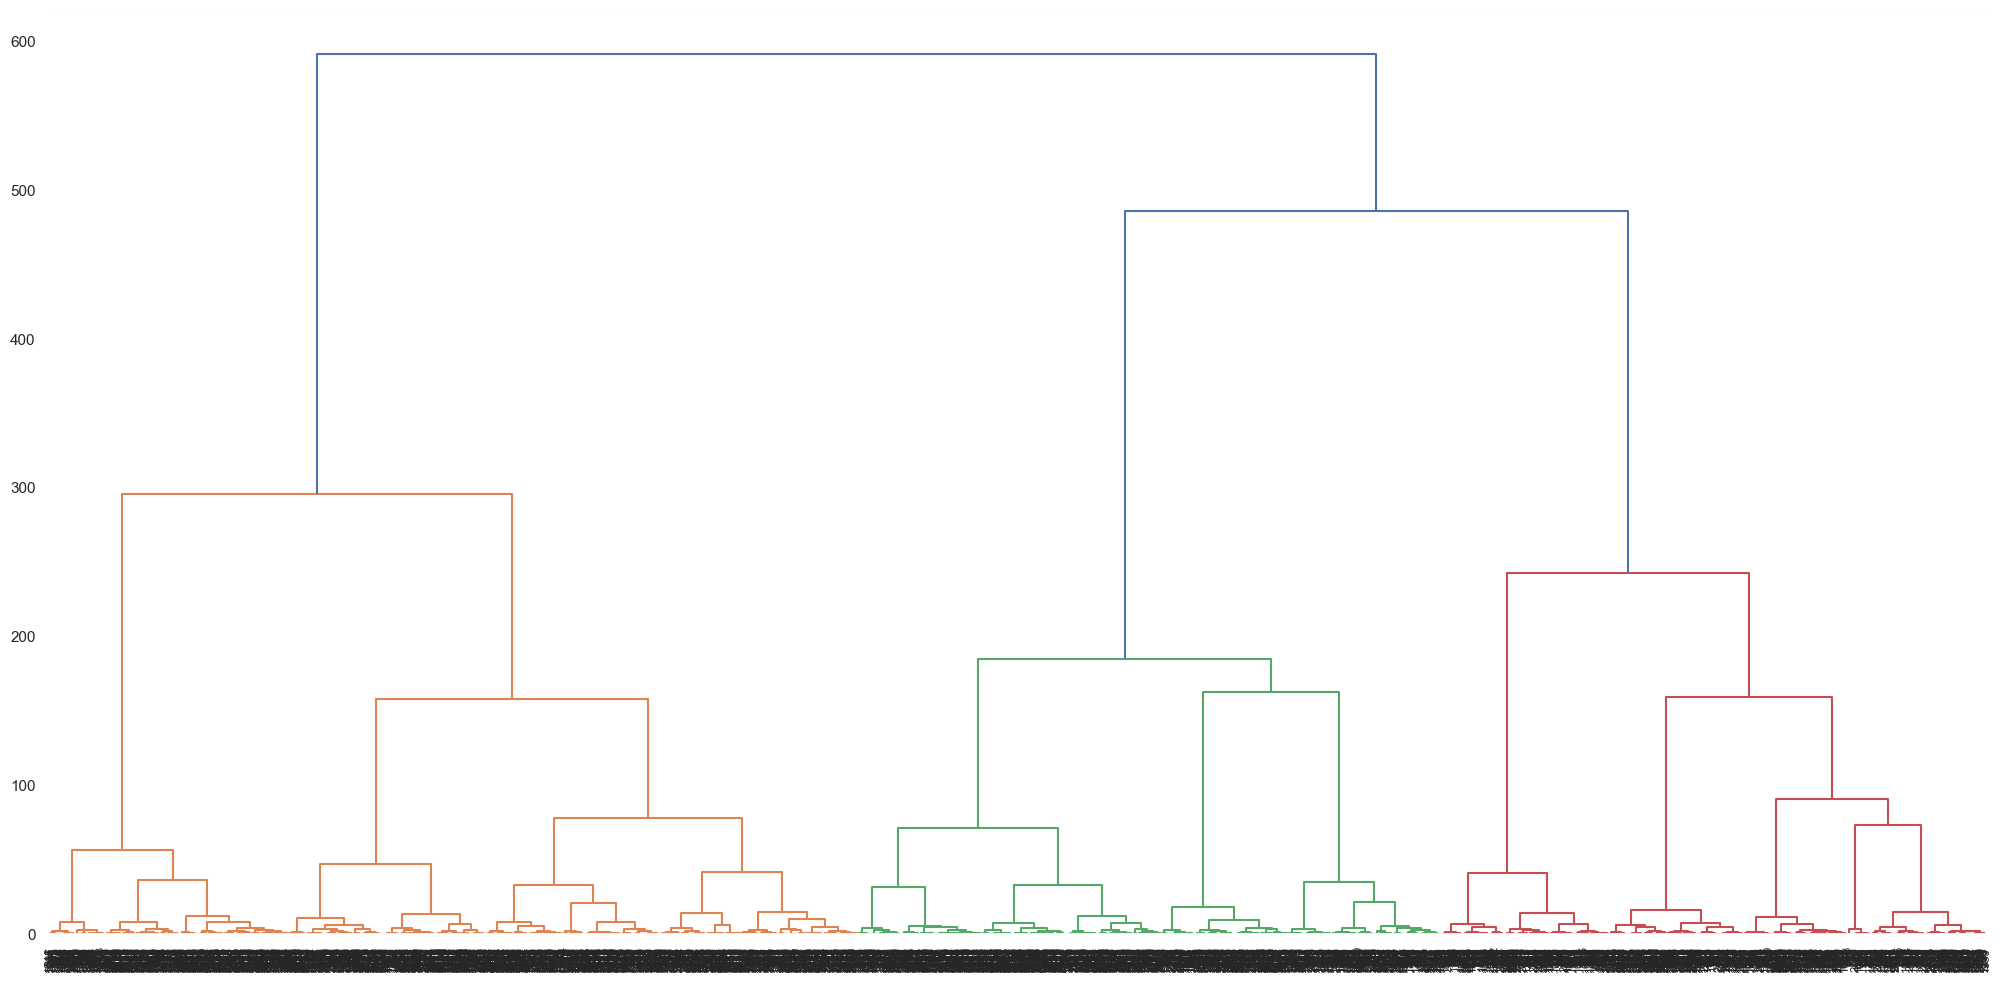

In [103]:
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
plt.plot()

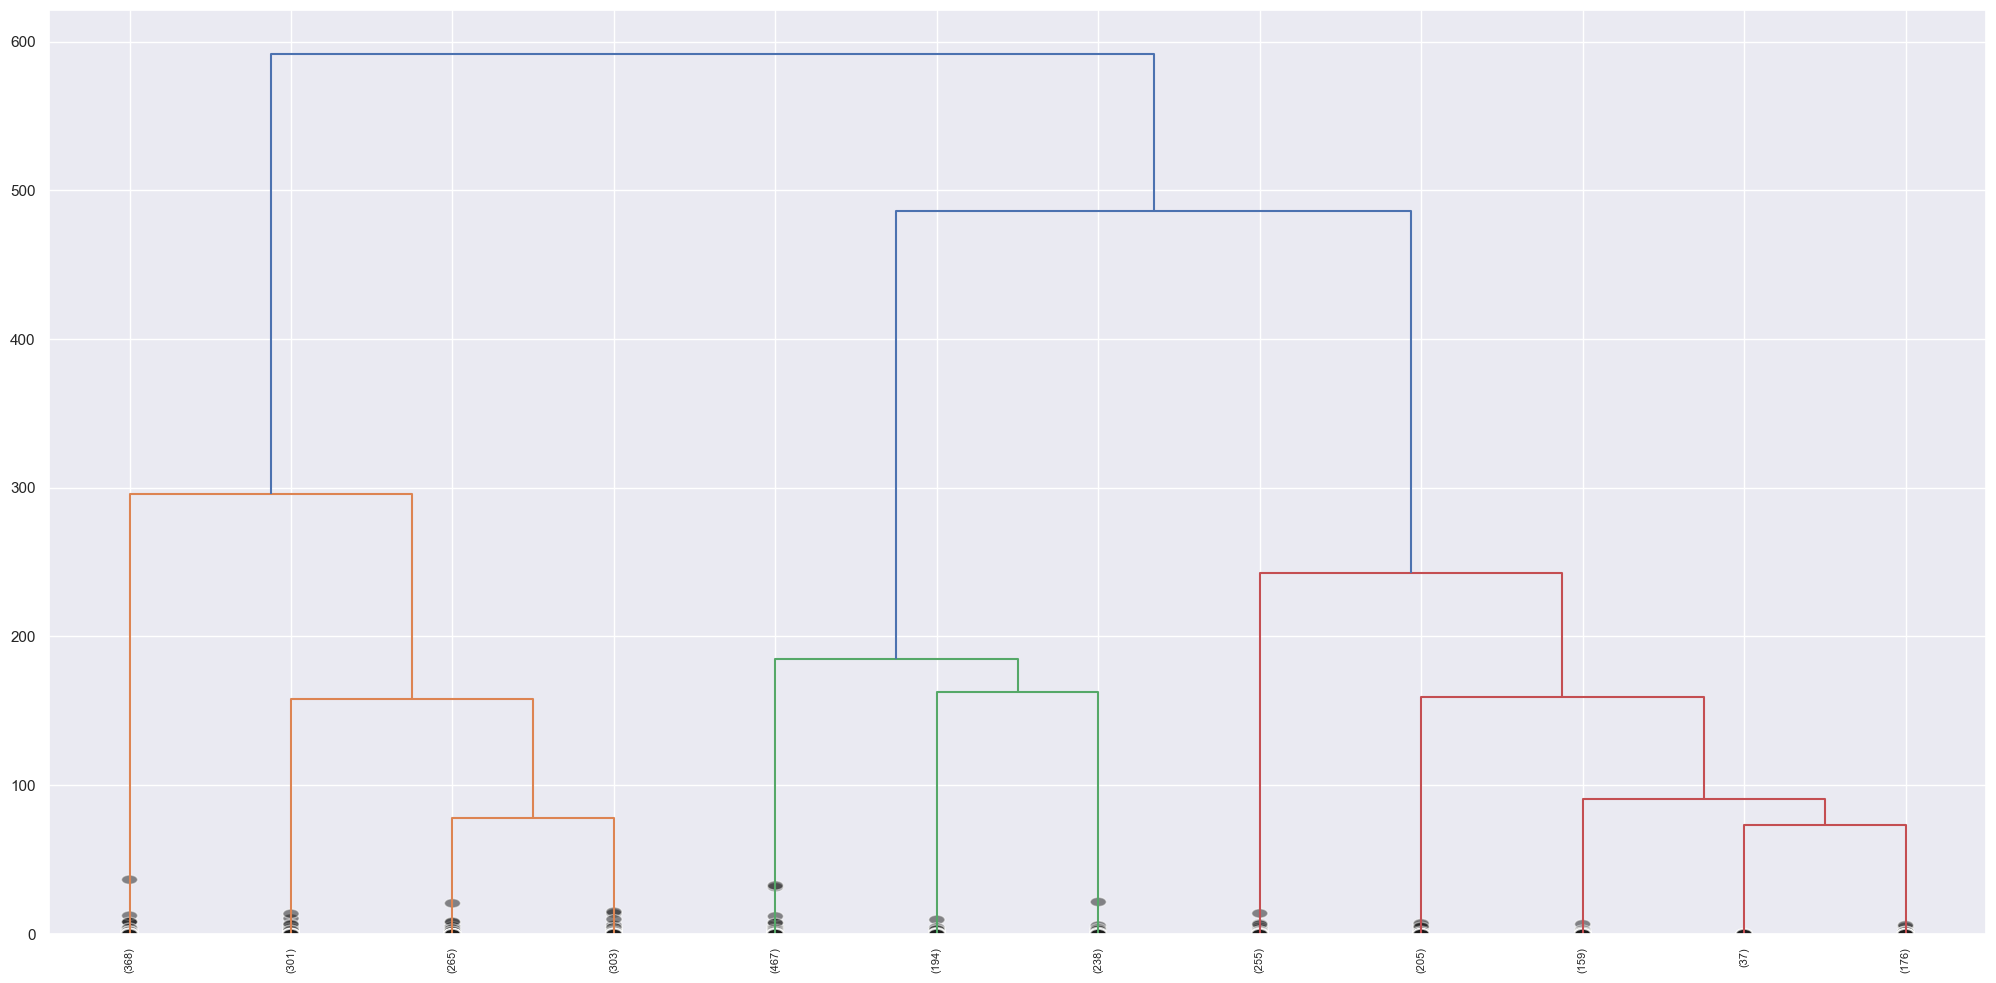

In [104]:
hc.dendrogram(hc_model, truncate_mode='lastp',p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.show()

#### 7.1.3.1 Hierarchical Clustering Silhouette Score

In [83]:
hc_list = []
for k in clusters:
    # define
    hc_model = hc.linkage(X,'ward')

    #training

    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performace

    hc_list.append(mt.silhouette_score(X, labels, metric='euclidean'))

Text(0.5, 1.0, 'Silhouette Score x K')

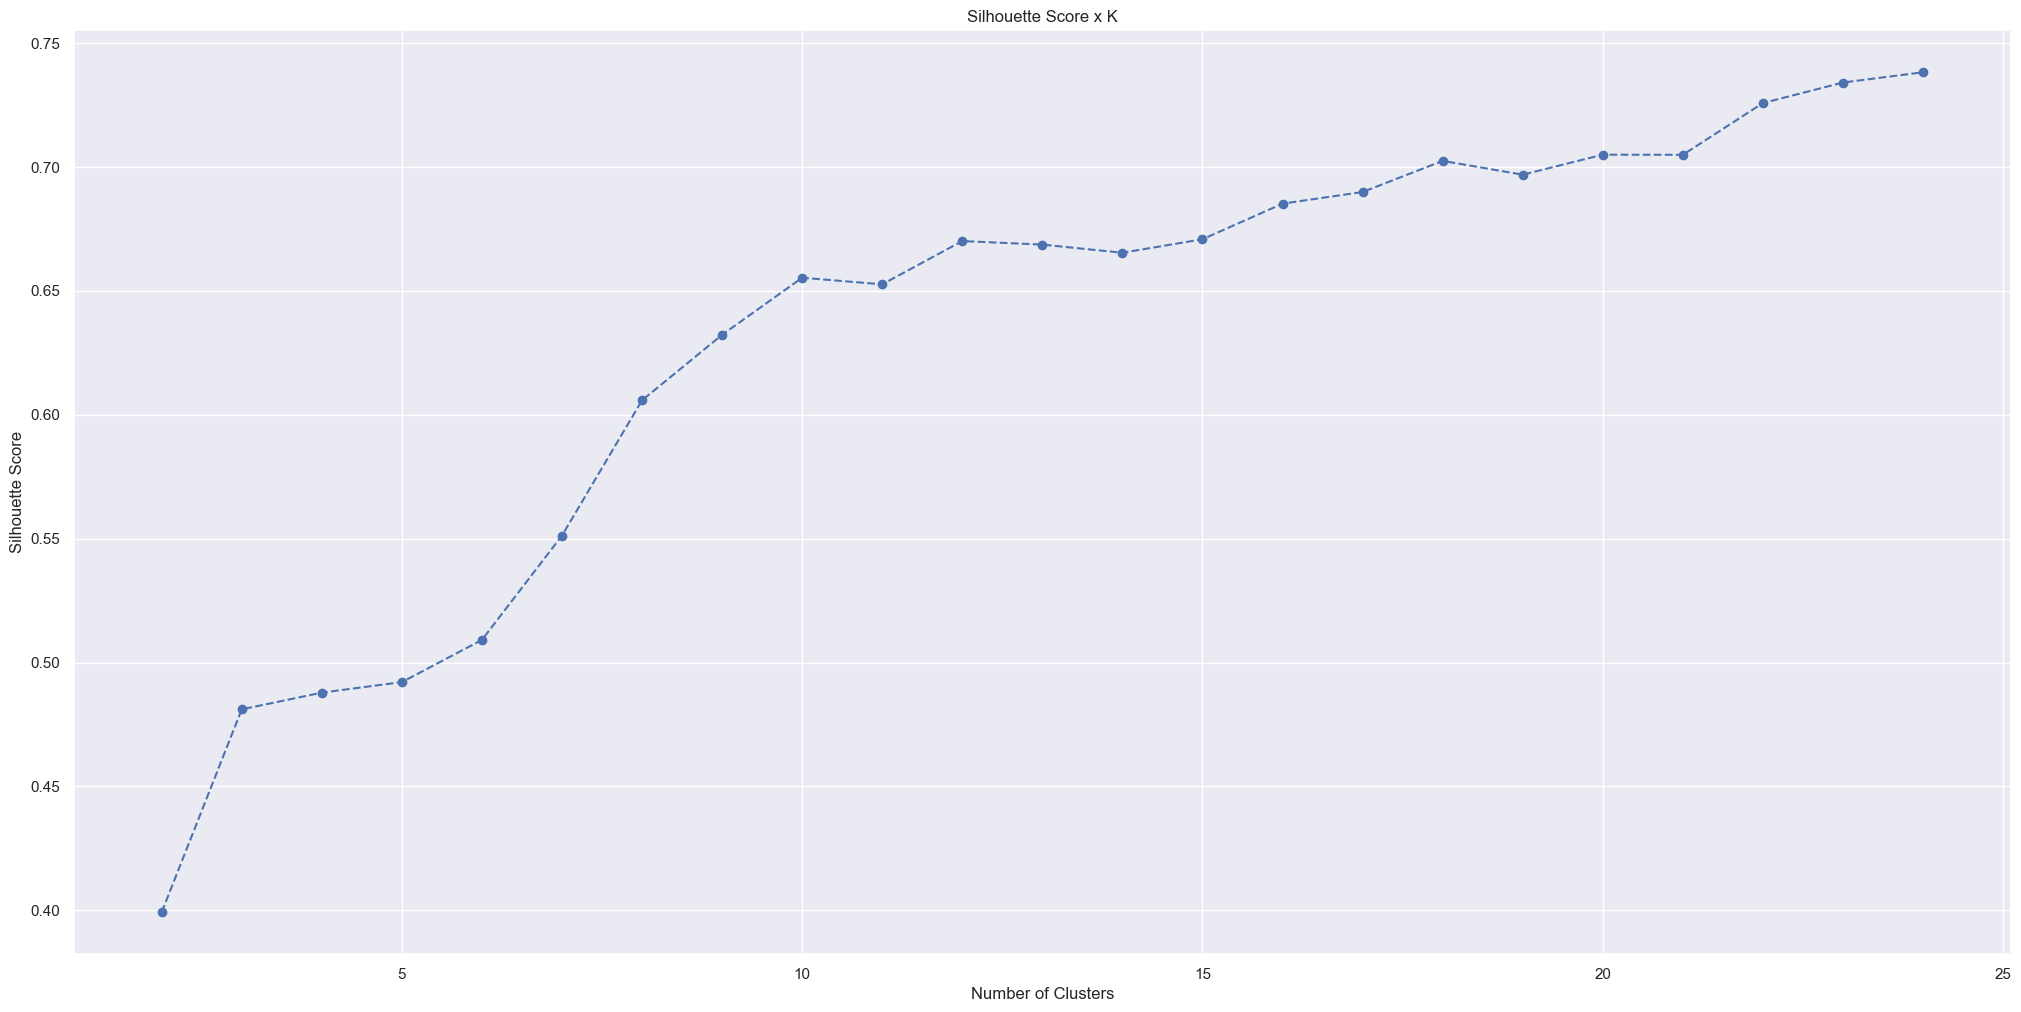

In [84]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### 7.1.4 DBSCAN

In [178]:
eps = 2
min_samples = 20

# definition

dbscan_model = ct.DBSCAN(eps=eps, min_samples=min_samples)

# training

labels = dbscan_model.fit_predict( X )

# performace

sil = mt.silhouette_score(X, labels, metric='euclidean')
print(sil)

0.5995432


In [179]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [180]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

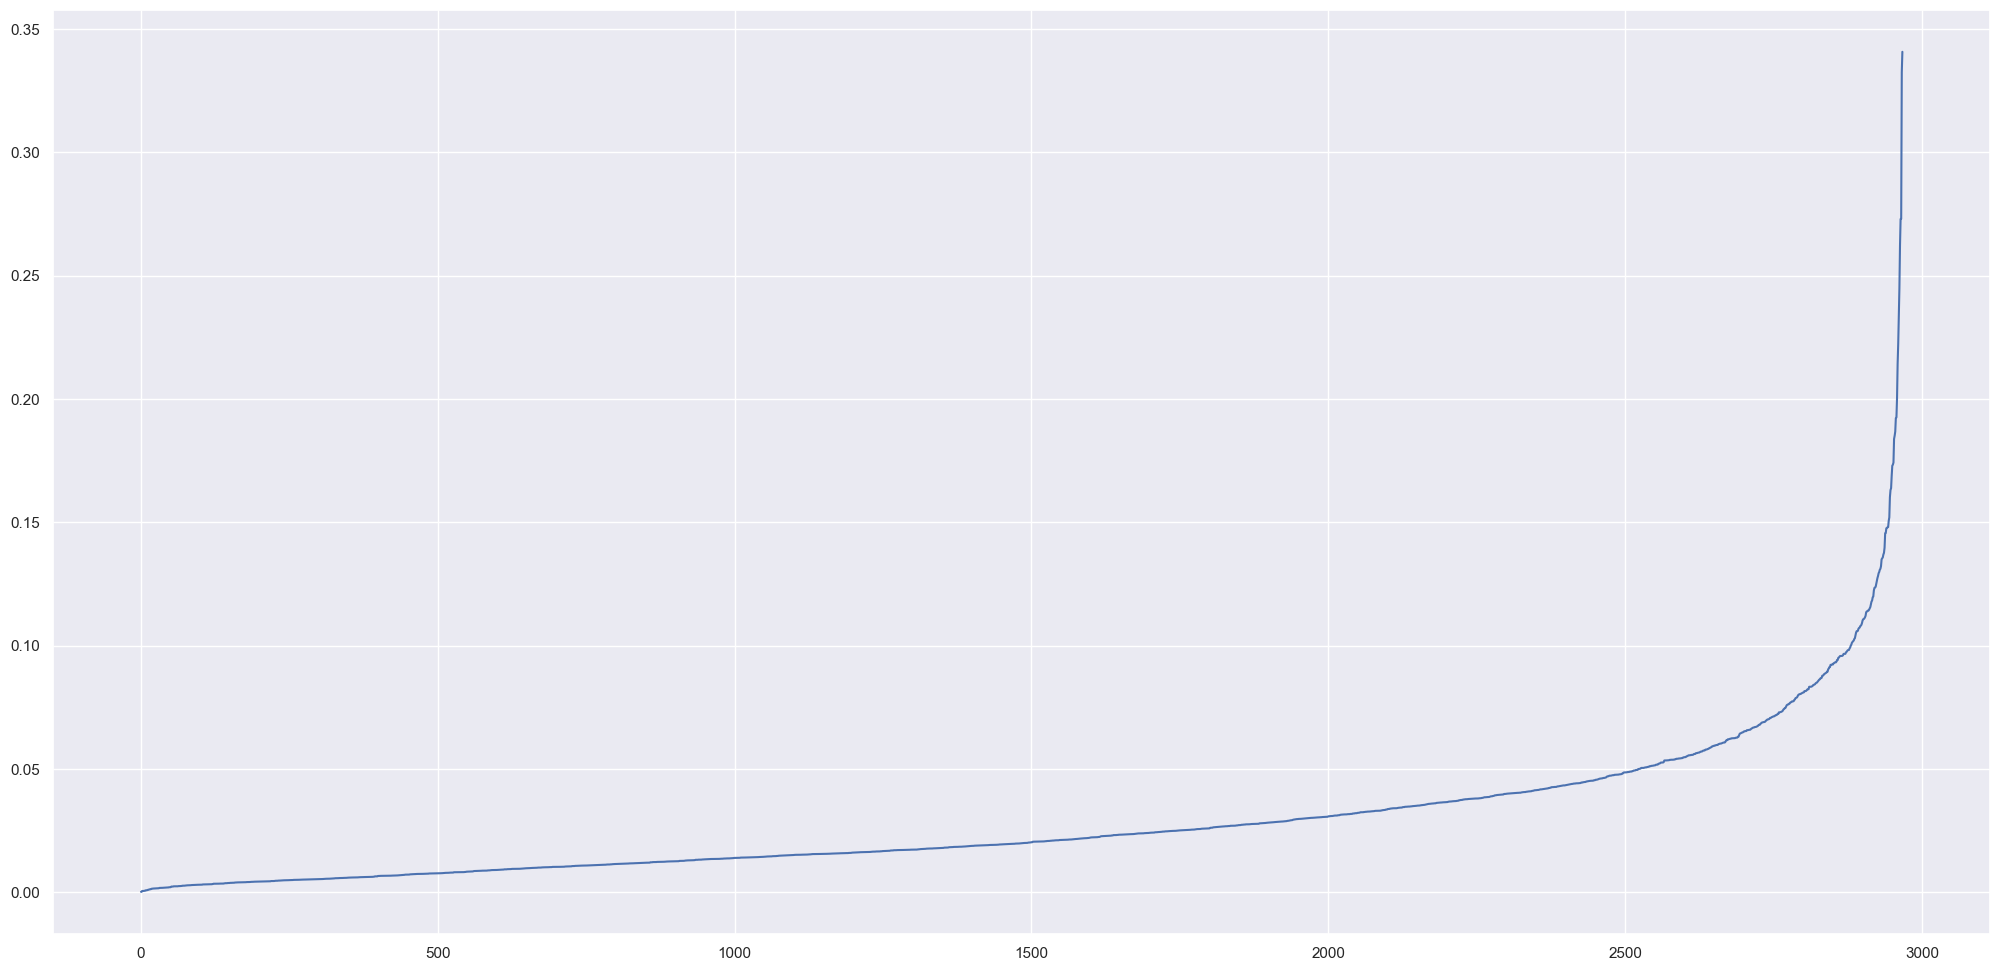

In [181]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [132]:
dbscan_list = [0.0, 0.0, 0.3137591845596463, 0.0, 0.0, 0.0]

### 7.1.5 Results

In [85]:
# Model Name:  | k=2 | k=3 | k=4 | k=5 | ...
# Kmeans          SS    SS    SS    SS   ...
# GMM             SS    SS    SS    SS   ...
# HC              SS    SS    SS    SS   ...
# DBSCAN          SS    SS    SS    SS   ...

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list
     #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [86]:
df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.424868,0.416592,0.461694,0.467452,0.535080,0.559438,0.609235,0.622632,0.630364,0.657577,0.658450,0.652480,0.639726,0.664088,0.643984,0.664169,0.639615,0.690402,0.703700,0.677488,0.726751,0.719520,0.716315
GMM,0.425074,0.422286,0.452998,0.512734,0.536034,0.534418,0.605325,0.617339,0.650281,0.672770,0.664407,0.654497,0.621170,0.666857,0.659623,0.658861,0.657265,0.667064,0.645681,0.720517,0.709918,0.704933,0.720672
HC,0.399190,0.481091,0.487837,0.492096,0.509117,0.551239,0.605851,0.632279,0.655315,0.652661,0.670117,0.668696,0.665398,0.670848,0.685227,0.689919,0.702487,0.696911,0.704995,0.704942,0.725829,0.734115,0.738263


## 7.1 Within-Cluster Sum of Square (WWS)

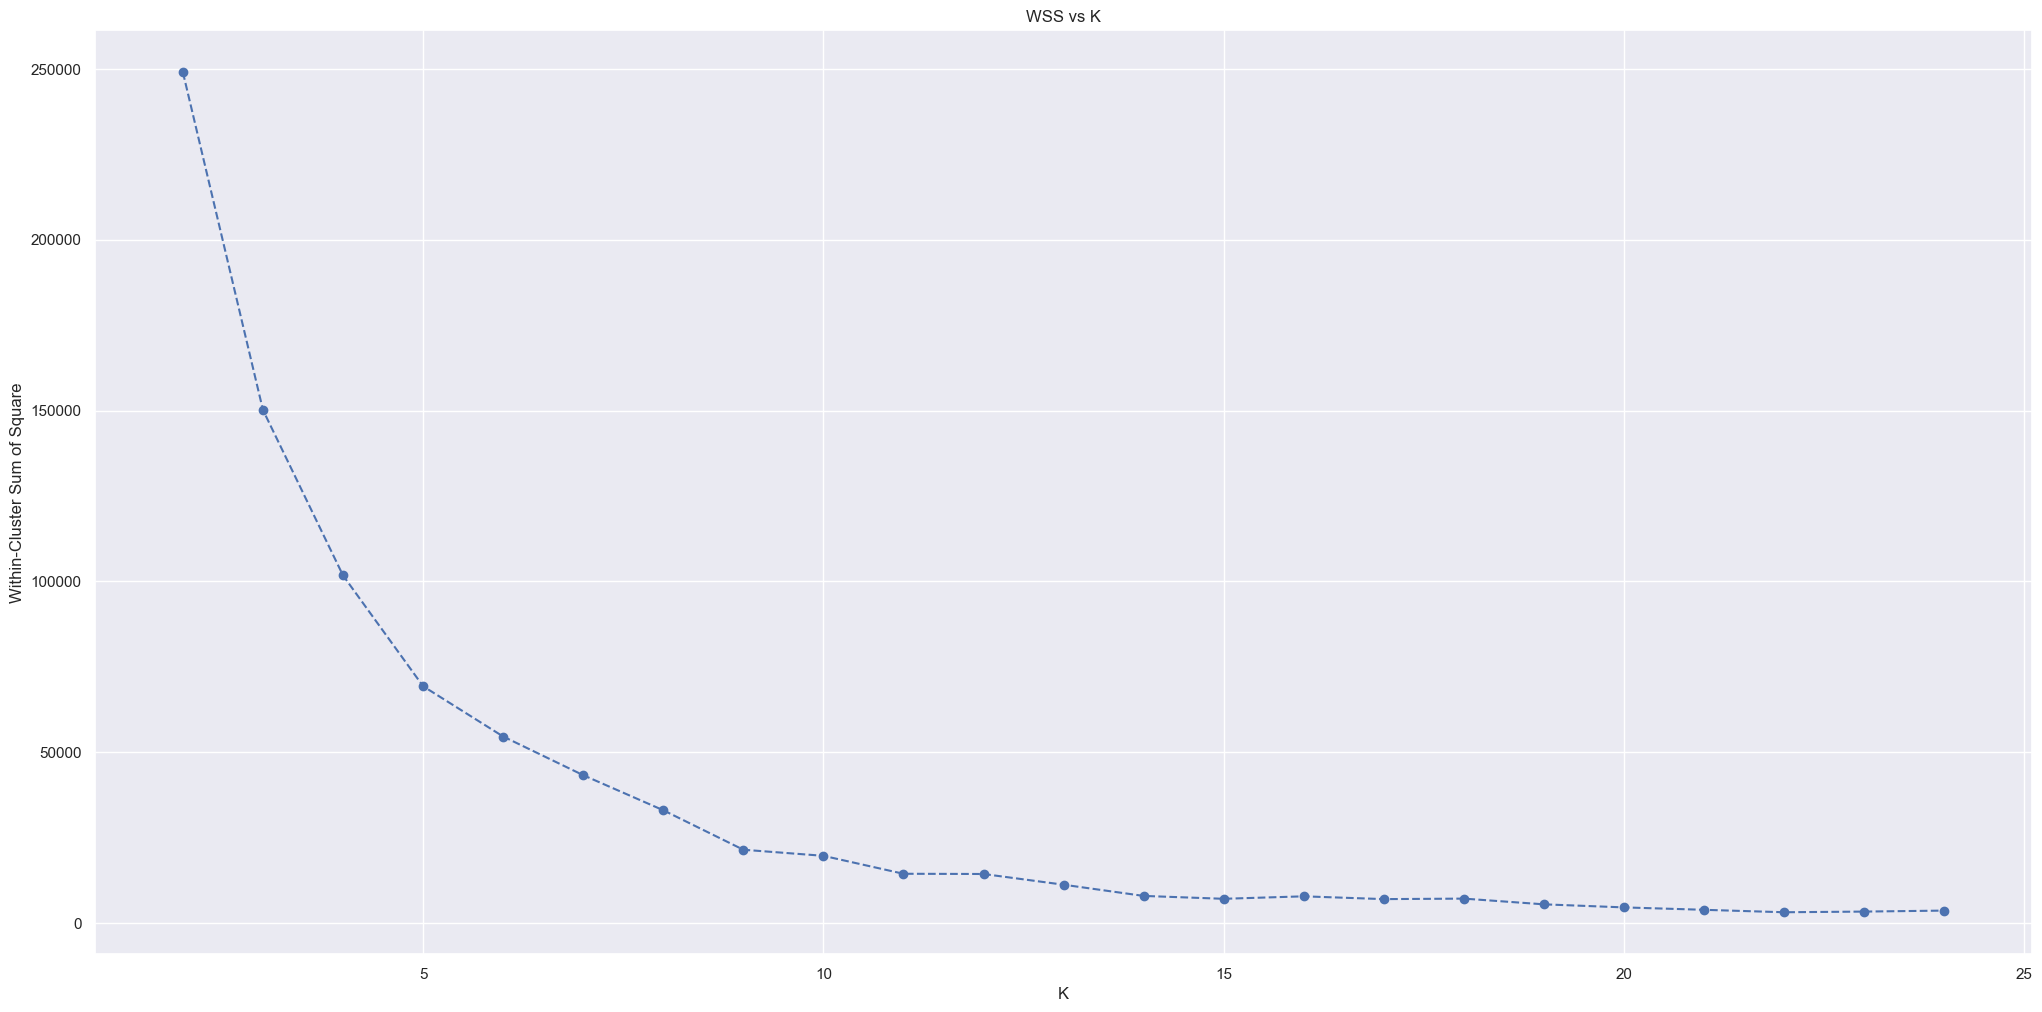

In [87]:
wss = []

for k in clusters:
    # definition
    model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # training/fit
    model.fit (X)

    # validation
    wss.append(model.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

## 7.2 Sillhouette Score

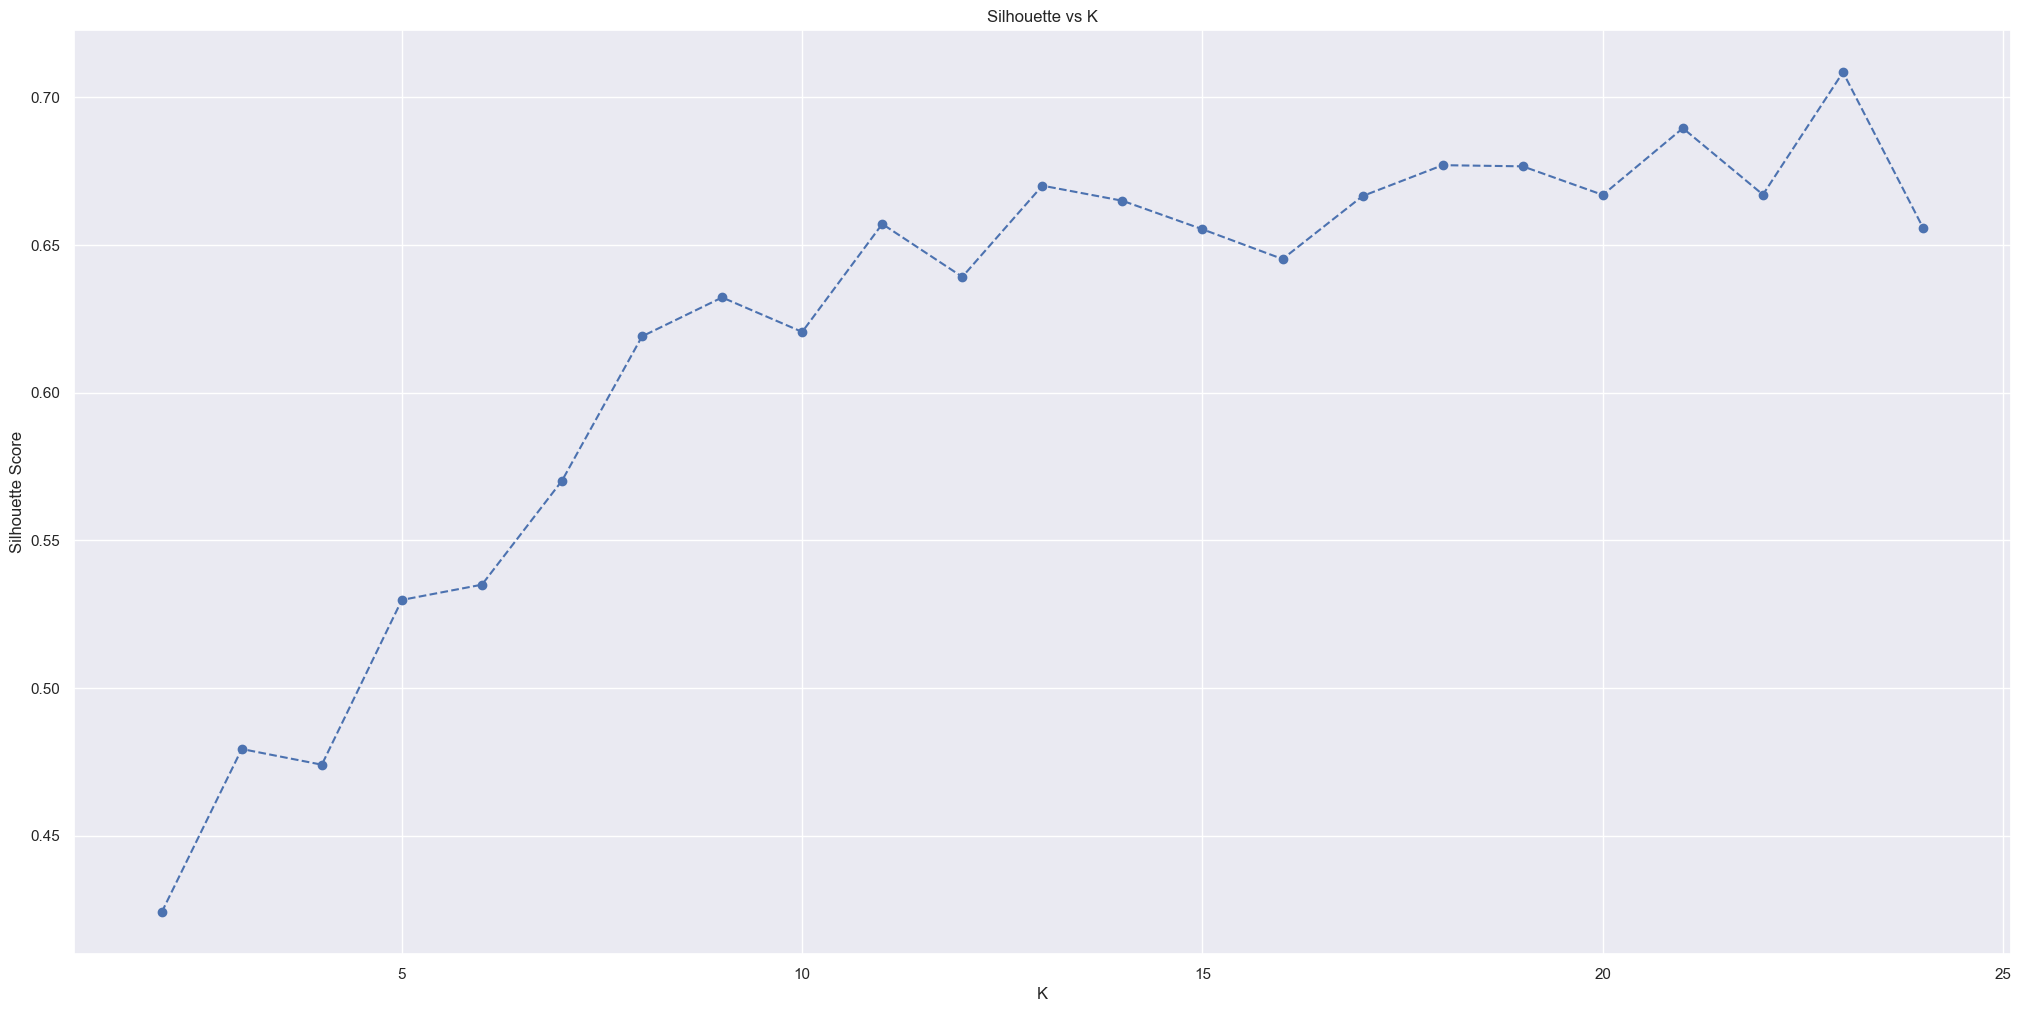

In [88]:
silhouette = []

for k in clusters:
    # definition
    model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # training/fit
    model.fit (X)

    # validation
    silhouette.append(mt.silhouette_score(X, model.labels_))

# plot silhouette
plt.plot(clusters, silhouette, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette vs K');

### 7.2.1 Silhouette Analysis

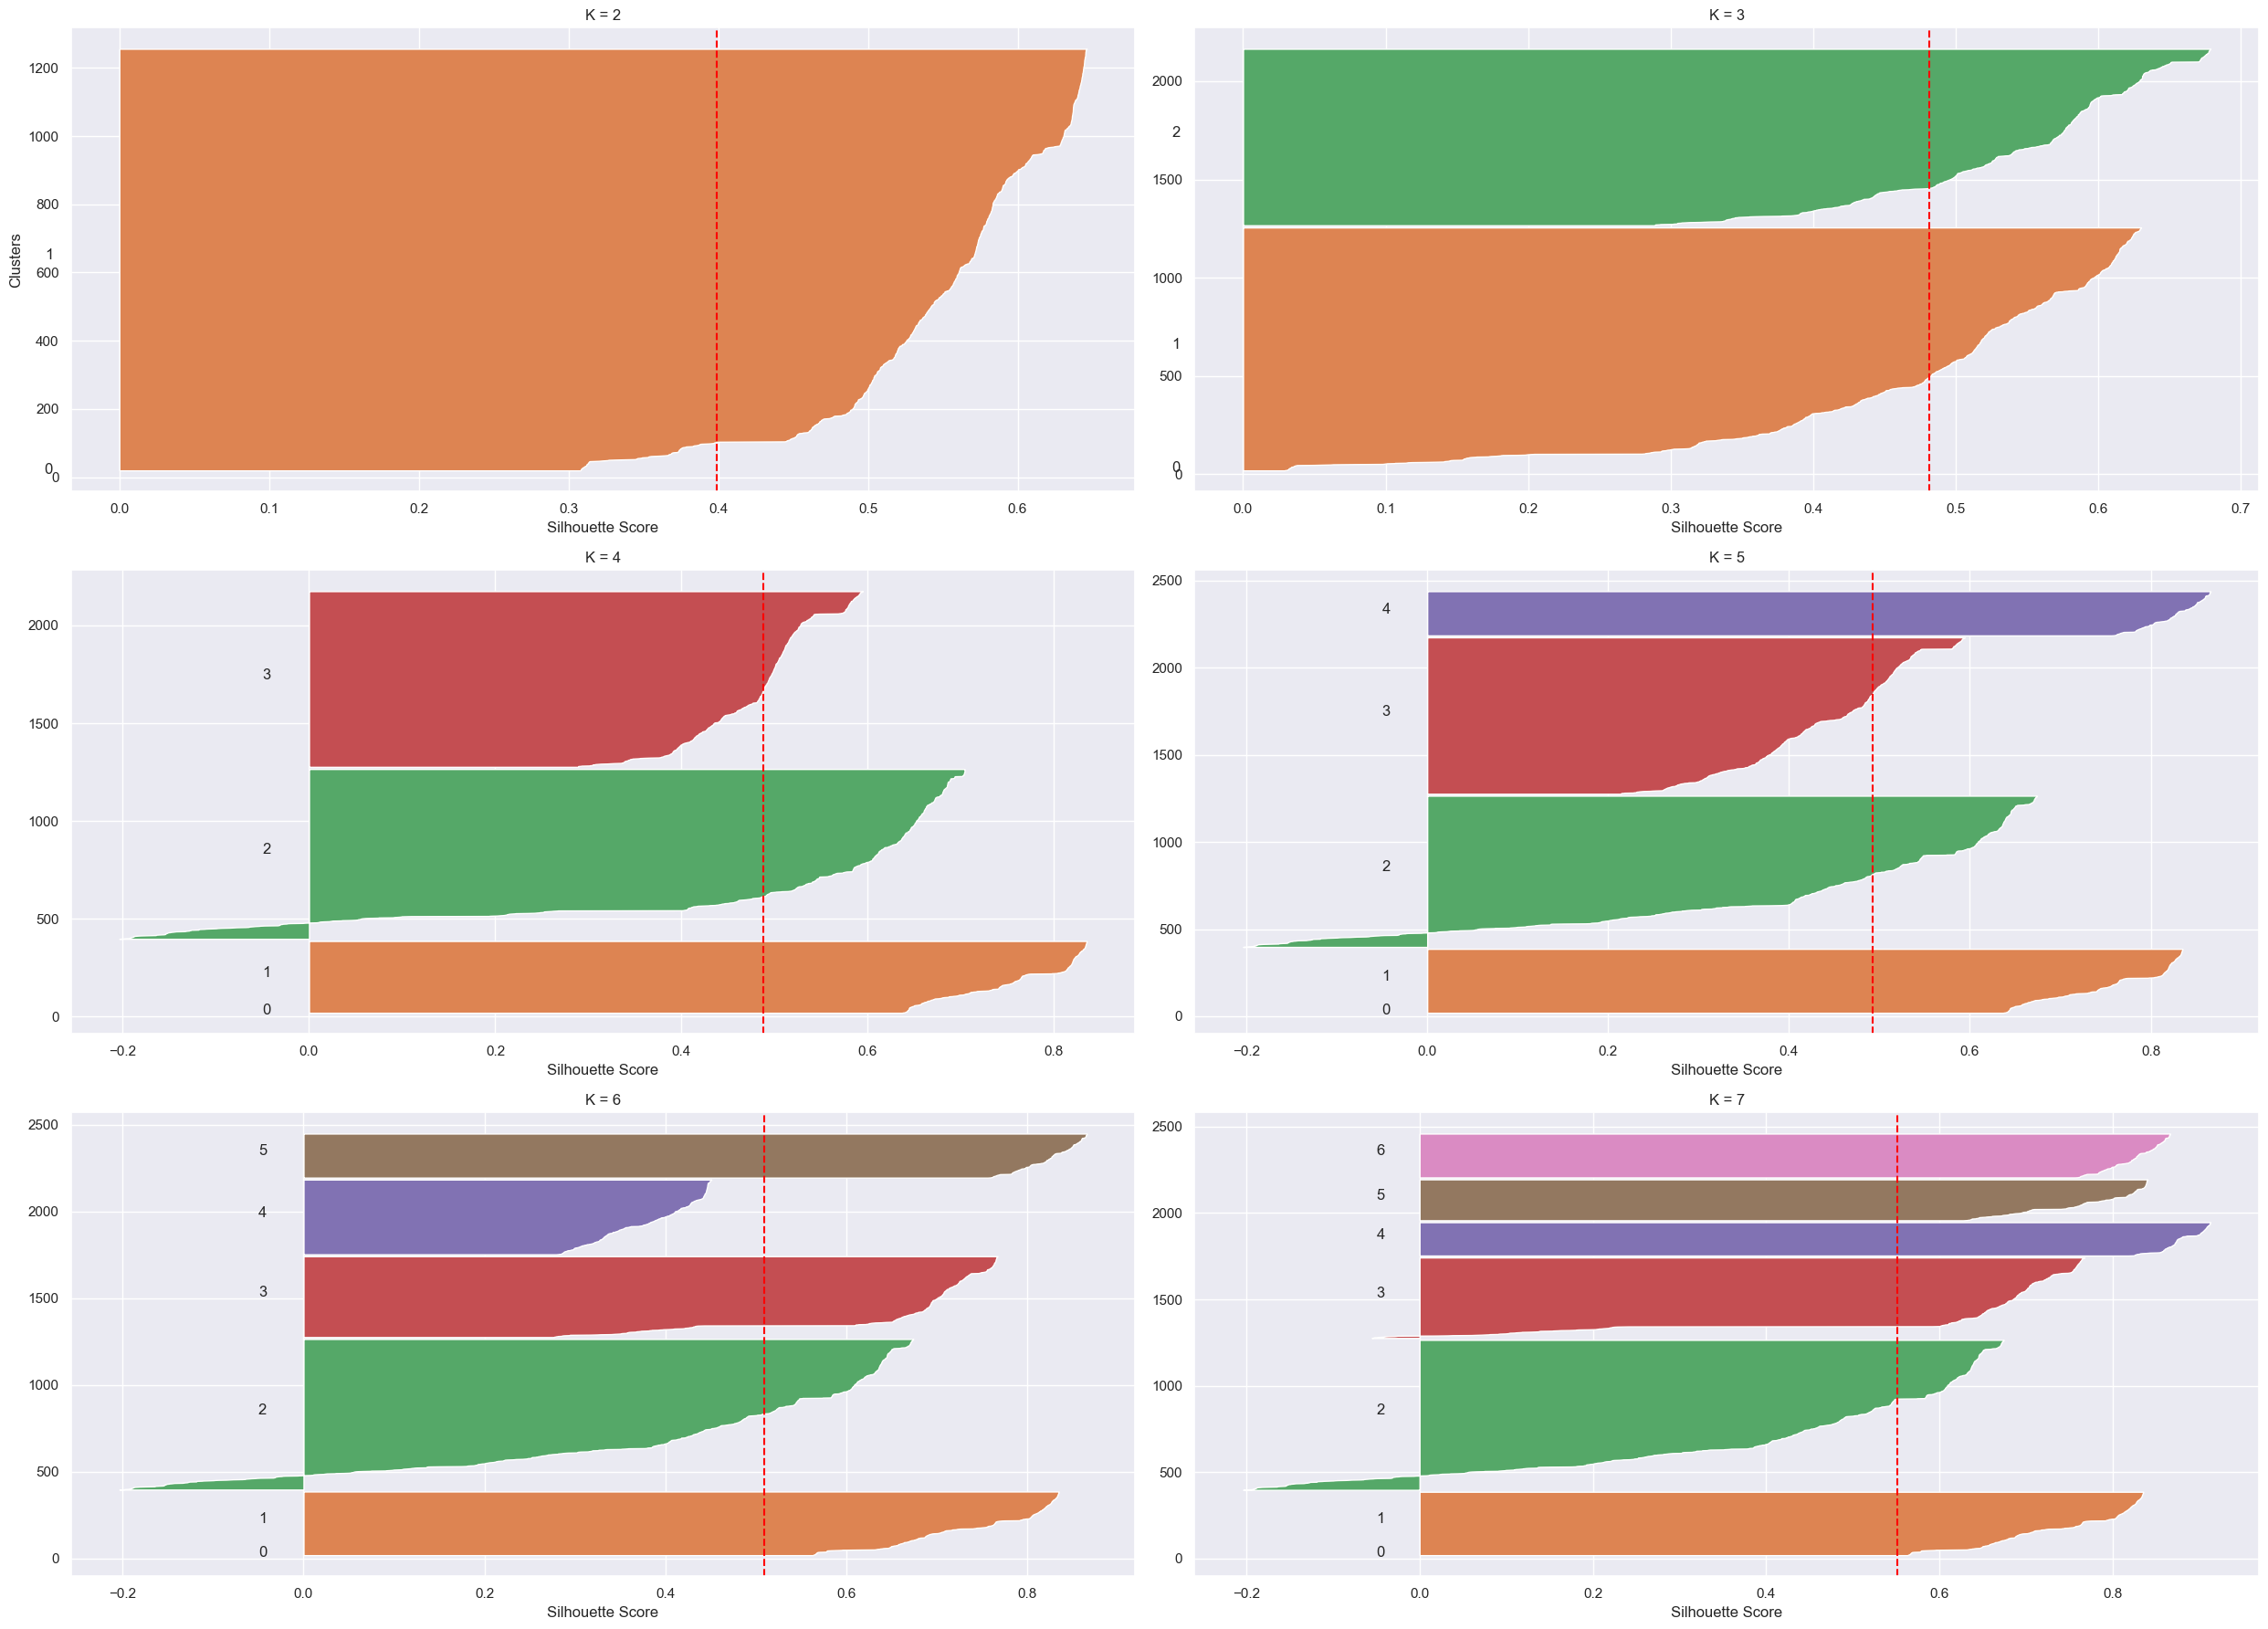

In [89]:
# Criando subplots dinâmicos para os gráficos
fig, axes = plt.subplots(3, 2, figsize=(25, 18))

axes = axes.flatten()

for ax, k in zip(axes, clusters):

    # Criando e treinando o modelo
    hc.linkage(X, 'ward')

    # model predict

    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    # performance

    silhouette_avg = mt.silhouette_score(X, labels)
    silhouette_values = mt.silhouette_samples(X, labels)

    y_lower = 10  # Inicializando a posição no eixo Y para o primeiro cluster

    for i in range(k):
        # Filtrando os valores de silhueta para cada cluster
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        # Criando a área preenchida do gráfico
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))  # Marcando o cluster
        y_lower = y_upper + 10  # Atualizando o Y para o próximo cluster

    # Linha média de silhueta
    ax.axvline(x=silhouette_avg, linestyle="--", color="red")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Clusters" if k == clusters[0] else "")
    ax.set_title(f"K = {k}")

# Ajustando o layout e exibindo os gráficos
plt.tight_layout()
plt.show()

# 8.0 Model Training

In [76]:
df8 = X.copy()

## 8.1 K-Means

In [96]:
# model definition
k=8
model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# training (fit)
model.fit (X)

#performance

labels = model.labels_

## 8.2 GMM

In [100]:
# definition
k = 8
model = mx.GaussianMixture(n_components=k, random_state=32, n_init=300)

# training

labels = model.fit_predict(X)


### 8.1.1 Cluster Validation

In [134]:
# WSS (Within-cluster sum of square)
print ('WSS value: {}'.format(model.inertia_))

## SS (Silhouette Score)
print('Silhouette Score: {}'.format(mt.silhouette_score(X, labels, metric='euclidean')))

WSS value: 14431.1015625
Silhouette Score: 0.6571064591407776


# 9.0 Cluster Analysis

In [101]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,2.488963,10.027324,0
1,-5.536704,15.134569,7
2,-1.865603,-4.041065,3
3,21.166323,9.363273,4
4,11.099811,-5.629389,5


In [193]:
# df9 = df4.copy()
# df9['cluster'] = labels

In [102]:
df9.head()

,embedding_x,embedding_y,cluster
0,2.488963,10.027324,0
1,-5.536704,15.134569,7
2,-1.865603,-4.041065,3
3,21.166323,9.363273,4
4,11.099811,-5.629389,5


## 9.1 Visualization Inspections

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

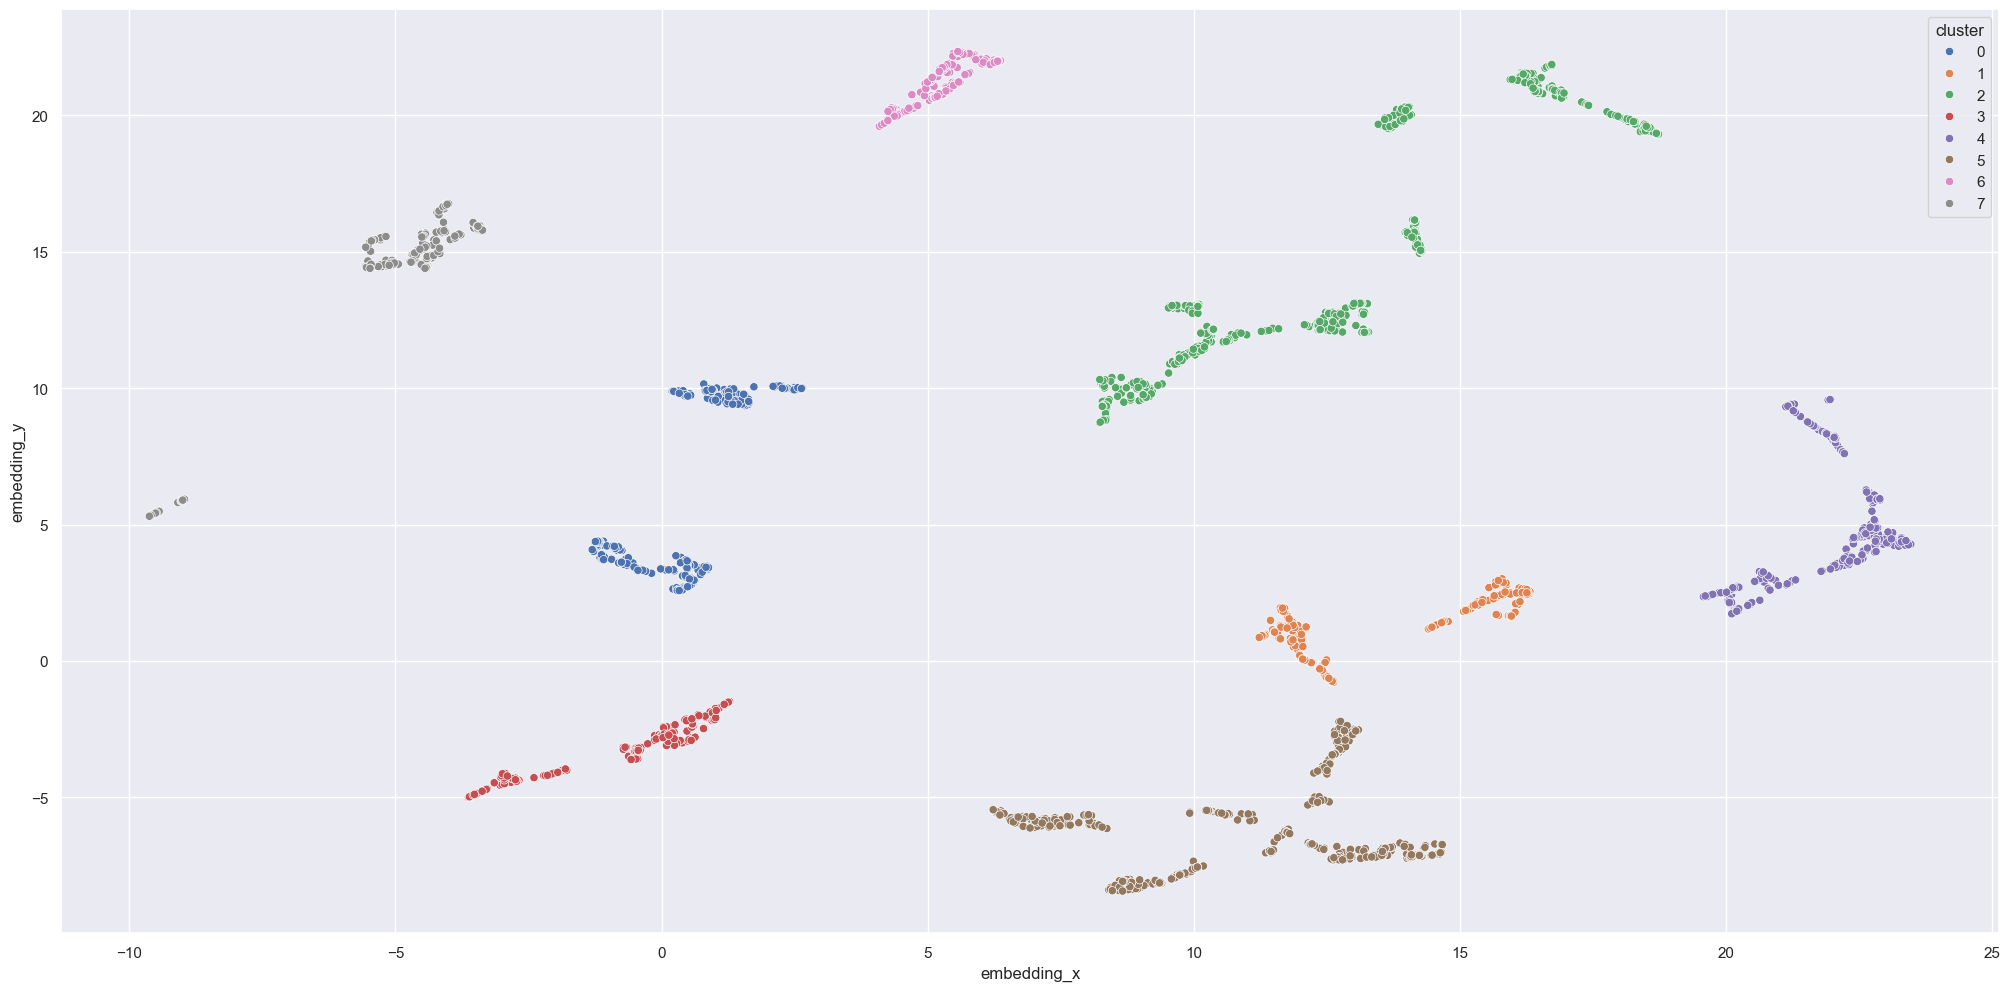

In [103]:
sns.scatterplot(x='embedding_x',y='embedding_y', data=df9, hue='cluster', palette='deep')

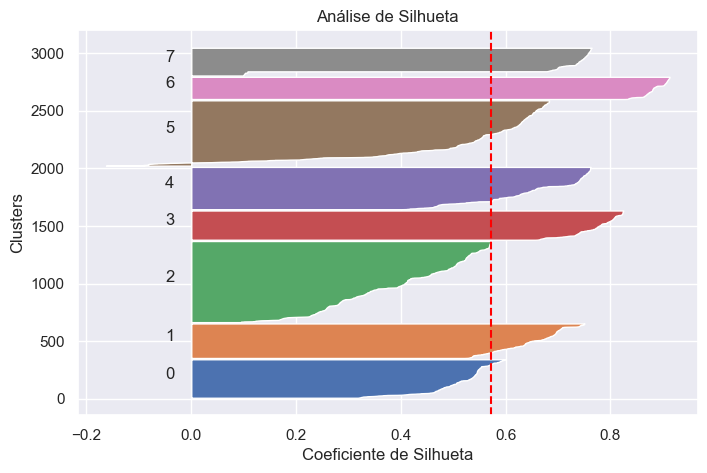

In [104]:

# Calculando a pontuação de silhueta
silhouette_avg = mt.silhouette_score(X, labels)
silhouette_values = mt.silhouette_samples(X, labels)

# Plotando os valores de silhueta
plt.figure(figsize=(8,5))
y_lower = 10
for i in range(k):
    cluster_silhouette_values = silhouette_values[labels == i]
    cluster_silhouette_values.sort()
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, linestyle="--", color="red")
plt.xlabel("Coeficiente de Silhueta")
plt.ylabel("Clusters")
plt.title("Análise de Silhueta")
plt.show()

## 9.2 2D-Plot


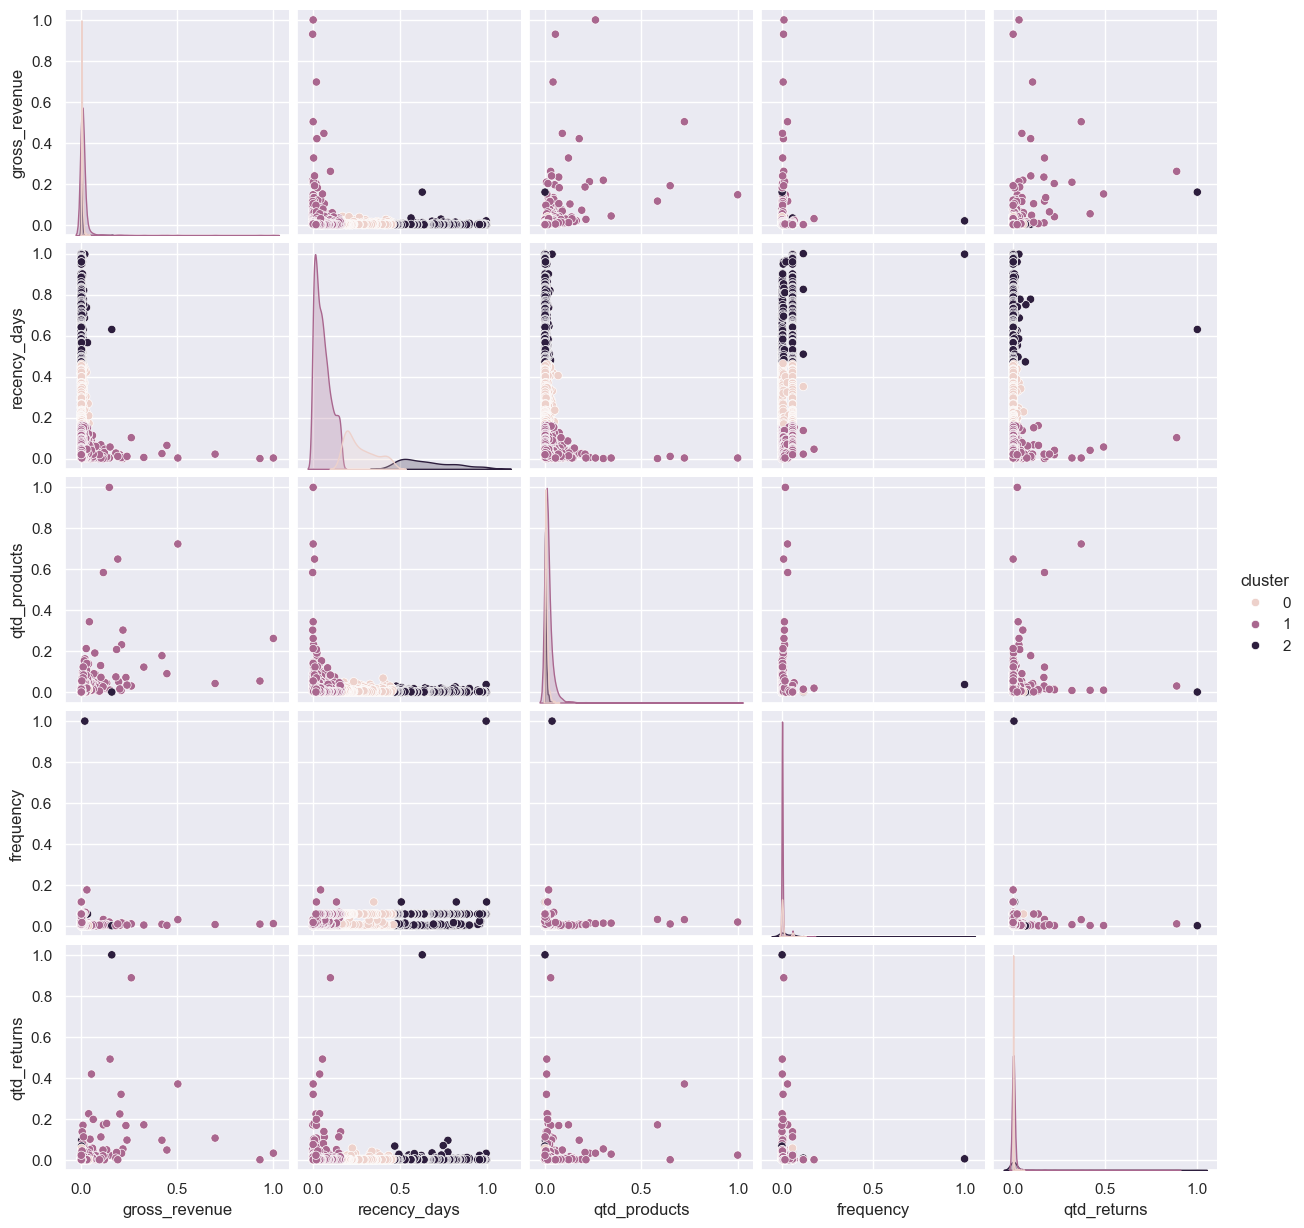

In [ ]:
# df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot (df_viz, hue='cluster')


## 9.3 UMAP

d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

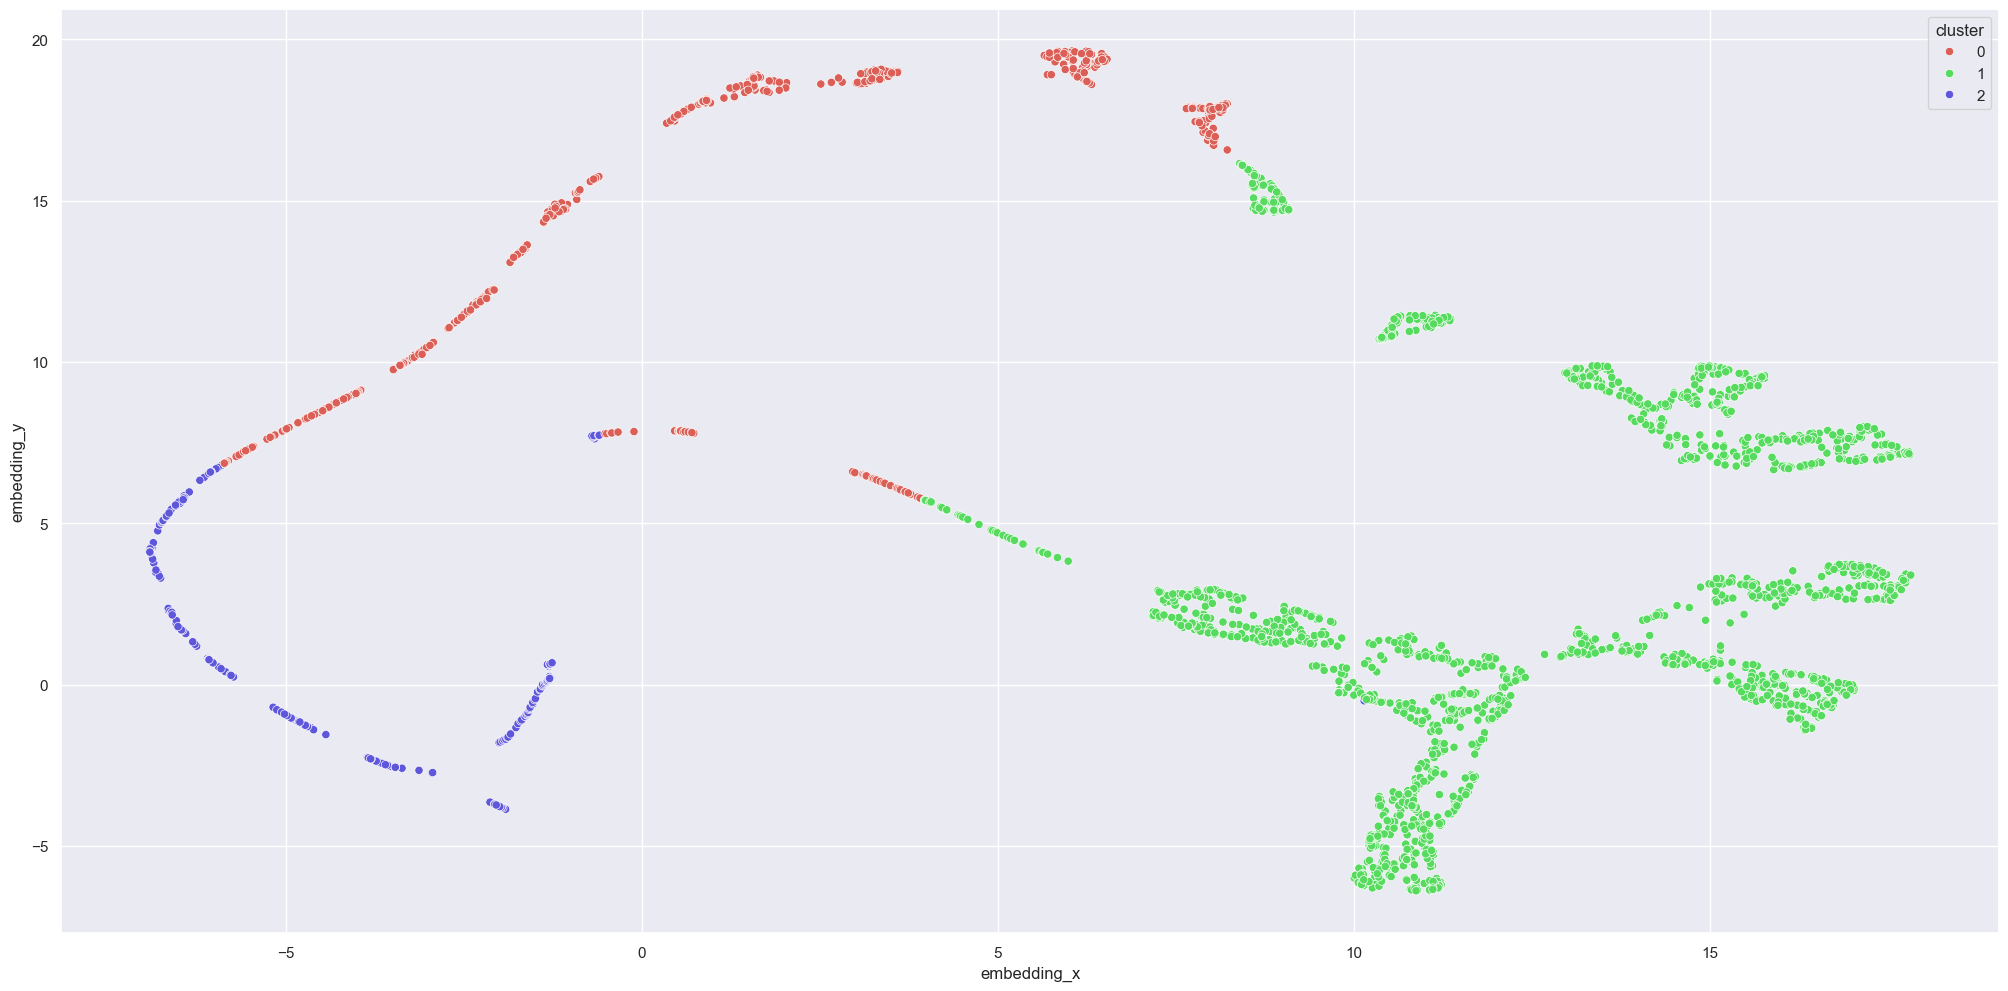

In [ ]:
# reducer = umap.UMAP(random_state=42, n_neighbors=20)
# embedding = reducer.fit_transform(X)

# # embedding

# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

# #plot UMAP
# sns.scatterplot (x='embedding_x', y='embedding_y',
#                  hue='cluster',
#                  palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
#                  data=df_viz)

## 9.2 Cluster Profile

In [105]:
df92 = df4[cols_select].copy()
df92['cluster'] = labels

df92.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtd_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,0
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,5


In [111]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Qtd products
df_qtd_products_no = df92[['qtd_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtd_products_no, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Qtd returns
df_qtd_returns = df92[['qtd_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtd_returns, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_products,frequency,qtd_returns
0,0,335,11.287062,3425.394448,31.988060,202.232836,0.087811,32.964179
1,1,301,10.141509,580.879668,85.069767,48.039867,0.159812,5.664452
2,2,705,23.753369,1300.613787,55.076596,92.116312,0.058679,14.526241
3,3,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
4,4,368,12.398922,799.574755,76.122283,61.801630,0.087762,6.016304
5,5,568,19.137466,360.831937,113.825704,24.966549,0.257344,5.517606
6,6,194,6.536388,1901.593711,40.412371,111.716495,0.039108,28.036082
7,7,242,8.153639,12015.856570,38.946281,300.632231,0.055379,202.037190


In [112]:
df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_products,frequency,qtd_returns
7,7,242,8.153639,12015.856570,38.946281,300.632231,0.055379,202.037190
3,3,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
0,0,335,11.287062,3425.394448,31.988060,202.232836,0.087811,32.964179
6,6,194,6.536388,1901.593711,40.412371,111.716495,0.039108,28.036082
2,2,705,23.753369,1300.613787,55.076596,92.116312,0.058679,14.526241
4,4,368,12.398922,799.574755,76.122283,61.801630,0.087762,6.016304
1,1,301,10.141509,580.879668,85.069767,48.039867,0.159812,5.664452
5,5,568,19.137466,360.831937,113.825704,24.966549,0.257344,5.517606


3. Cluster Insiders
0. Cluster More Products
6. Cluster Spend Money
5. Cluster Spend Even more Money
1. Cluster More recency
4. Cluster Less 1k
7. Cluster Propaganda
2. Cluster Propaganda 2

### Cluster 01: (Canditado ao Loyalty)
        - Número de customers: 6 (0.14% dos customers)
        - Recência em média: 7 dias
        - Compras em média: 89 compras
        - Receita em média: $182.182,00 dólares

### Cluster 02:
        - Número de customers: 31 (0.7 % dos customers)
        - Recência em média: 14 dias
        - Compras em média: 53 compras 
        - Receita em média: $40.543,52 dólares

### Cluster 03:
        - Número de customers: 4.335 (99% dos customers)
        - Recência em média: 92 dias
        - Compras em média: 5 compras
        - Receita em média: $1.372,57 dólares

# 10.0 Análise Exploratória de Dados

In [113]:
df10 = df92.copy()

## 10.1 MindMap de hipoteses

1. Fenomeno
2. Entidades (Customer, Location, Finance, Family)
3. Características da Entidade (Customer = Nome, Idade, Salário, Escolaridade)


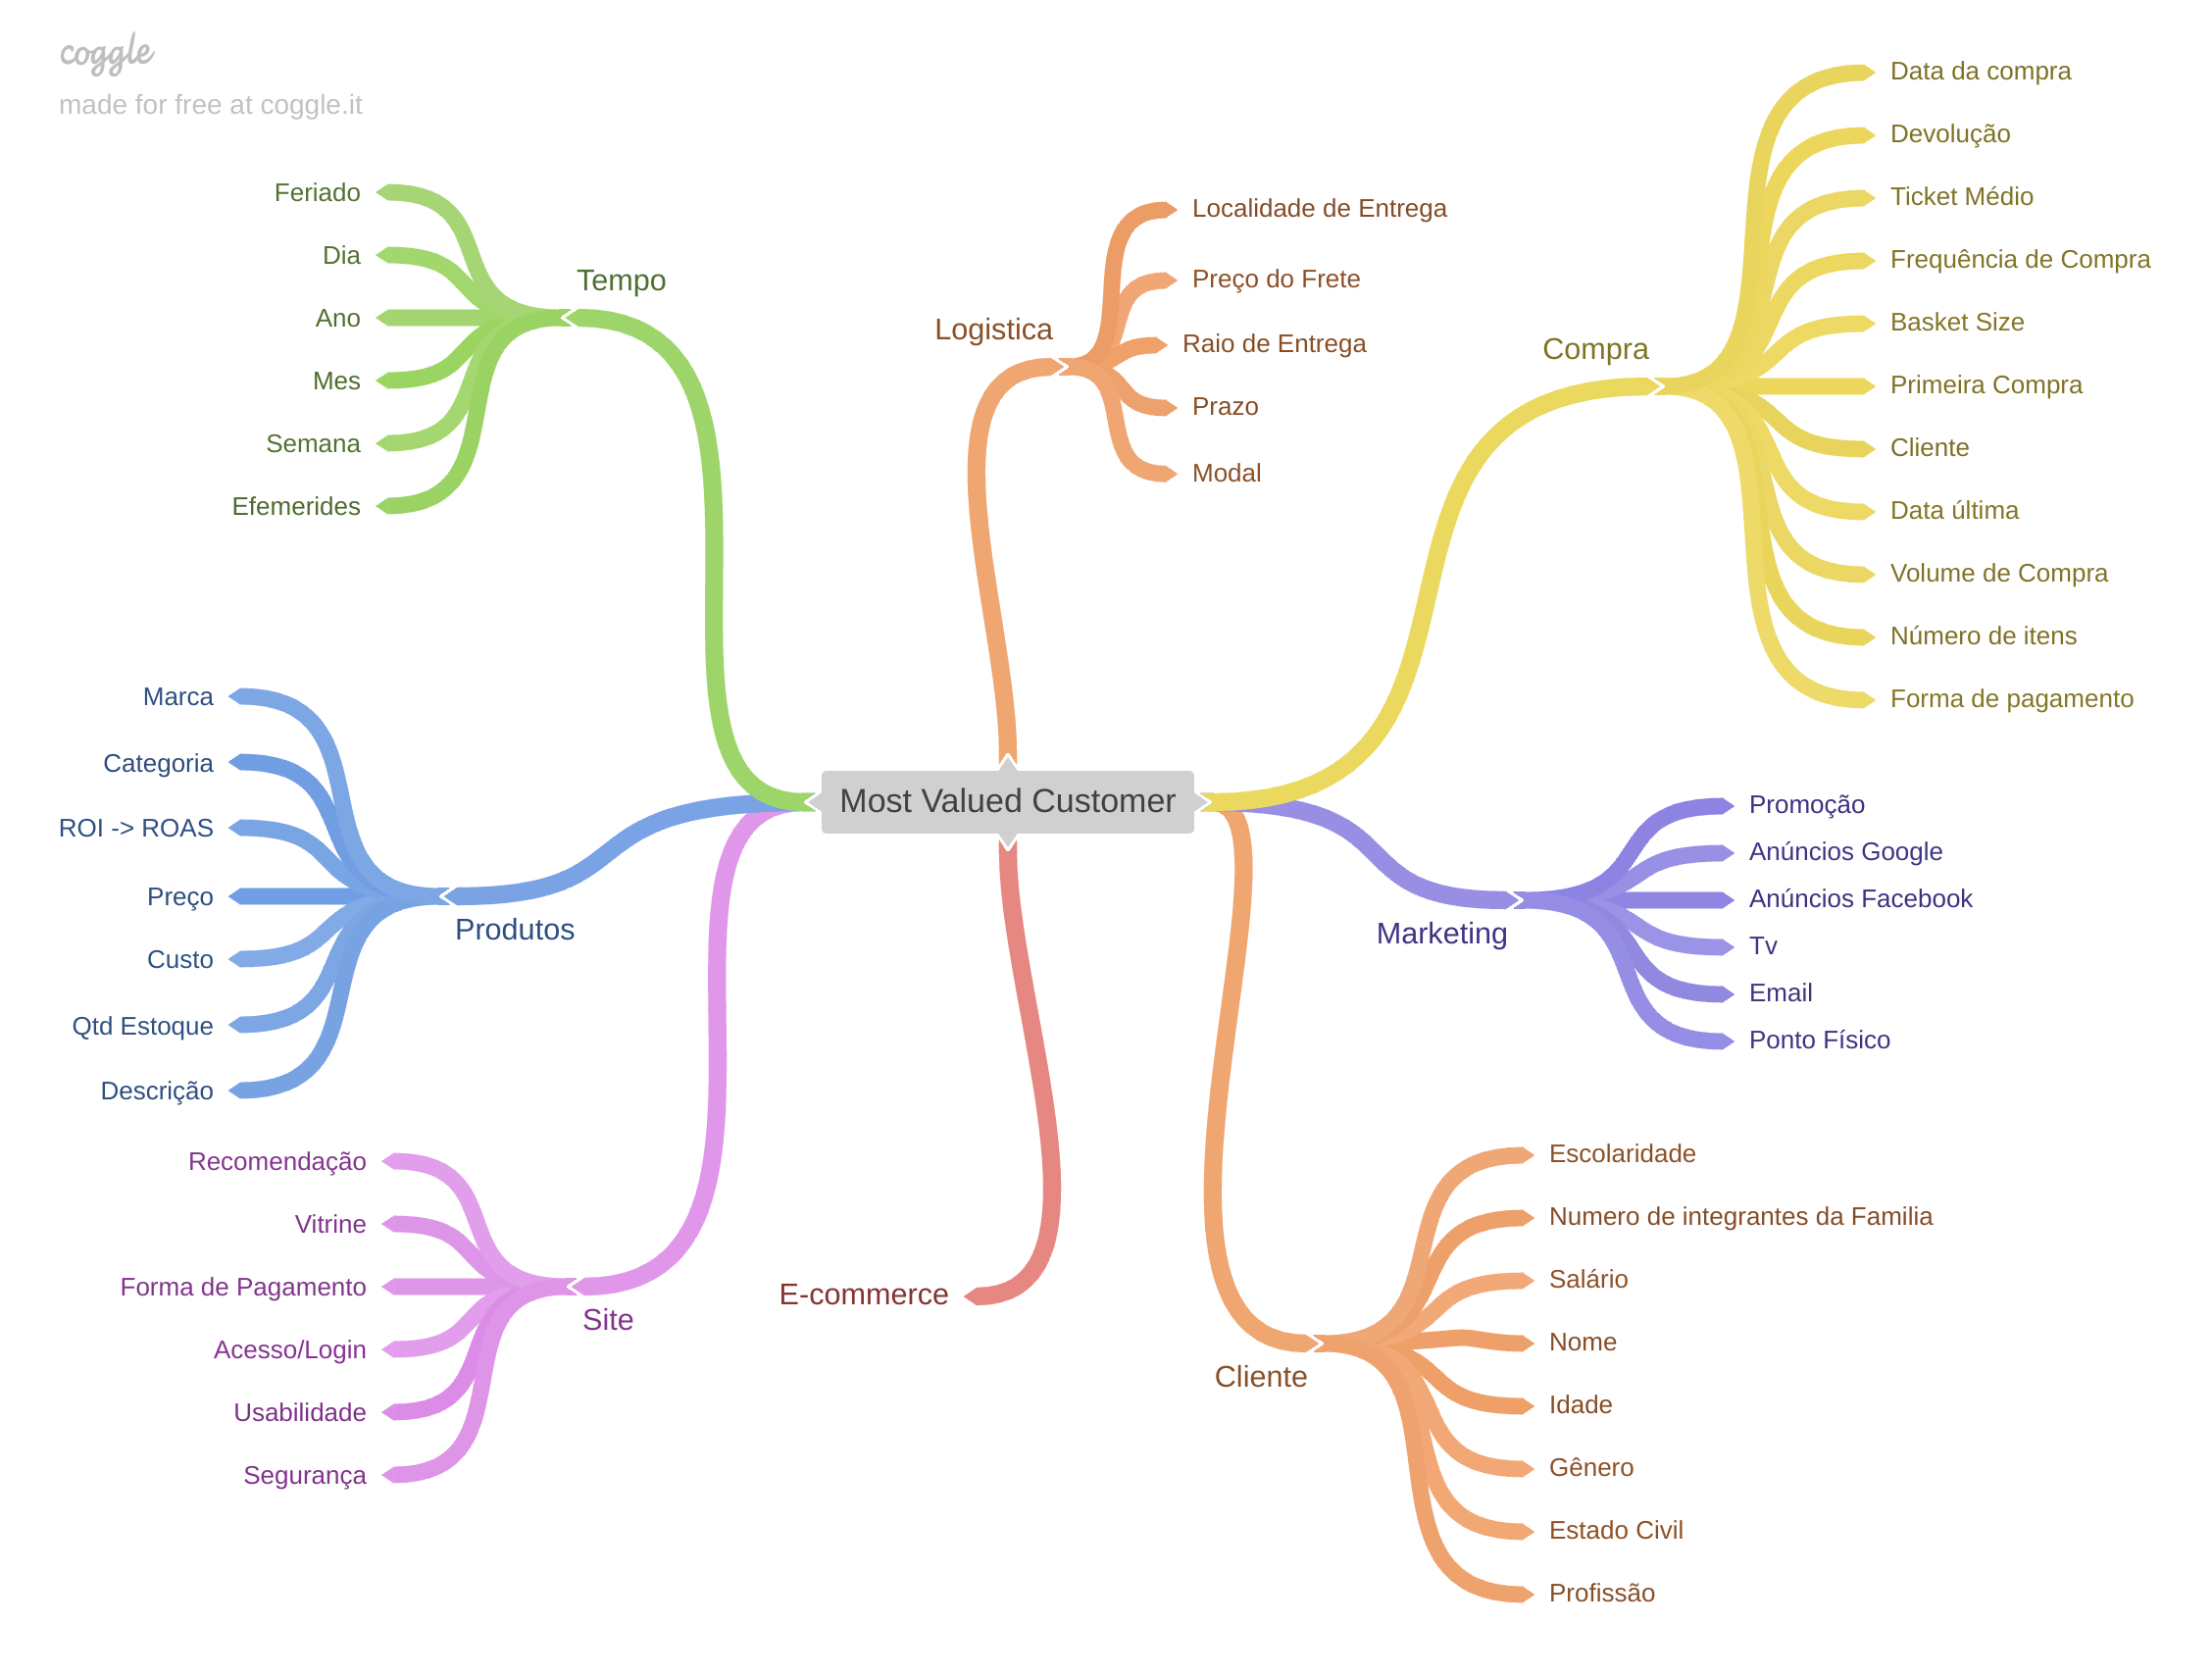

In [7]:
Image ('../imgs/Most_Valued_Customer.png')

## 10.2 Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

### Hipotese Compra

1. Afirmação | Cluster | Tamanho da base (chute)
- Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
- **Os clientes do cluster insider possuem um ticket médio de 10% acima do cluster More Products.**
- **Os clientes do cluster insiders possuem um basket size acima de 5 produtos.**
- **Os clientes do cluster insiders possuem um volume (produtos) de compra acima de 10% de compras.**
- **Os clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% de compras.**
- **Os clientes do cluster insiders tem uma número de devoluçao abaixo da média da base total de clientes.**
- **A mediana do faturamento pelos clientes do cluster insider é 10% maior que a mediana do faturamento geral**
  **de todos os preços dos produtos.**
- **O percentil do gmv comprados pelos clientes insiders.**

#### H1: Os clientes do cluster insiders possuem um volume de compra acima de 10% de compras.
**VERDADEIRO**: O cluster insiders possuem um volume de compra de produtos de 19.97%

In [114]:
# soma qtd de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 7, 'qtd_products'].sum()
df_sales_total = df10.loc[:, 'qtd_products'].sum()

# soma da qtd de produtos total
print(' % Sales Insiders: {:.2f} %'.format(100*(df_sales_insiders/df_sales_total)))

 % Sales Insiders: 19.97 %


#### H2: Os clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% de compras.
**VERDADEIRO**: O cluster insider possue um volume de GMV de 36.37%

In [115]:
# soma qtd de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtd de produtos total
print(' % GMV Insiders: {:.2f} %'.format(100*(df_gmv_insiders/df_gmv_total)))

 % GMV Insiders: 36.37 %


#### H3: Os clientes do cluster insiders tem uma número de devoluçao abaixo da média da base total de clientes.
**FALSO**: O cluster insiders tem a média de devoluções acima da média geral.

In [116]:
# media de devolucao do cluster insiders
df_returns_insiders = df10.loc[df10['cluster'] == 7, 'qtd_returns'].mean()
df_returns_total = df10.loc[:, 'qtd_returns'].mean()

# soma da qtd de produtos total
print(' Avg Return Insiders: {} vs Avg Return All: {}'.format(np.round(df_returns_insiders, 0),
                                                              np.round(df_returns_total, 0 )))

 Avg Return Insiders: 202.0 vs Avg Return All: 35.0


#### H4: A mediana do faturamento pelos clientes do cluster insider é 10% maior que a mediana do faturamento geral de todos os preços dos produtos.
**VERDADEIRA**: A mediana do faturamento é 127% acima da mediana

In [117]:
# mediana de gmv do insiders
df_mediam_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].median()

# mediana de gmv total
df_median_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_mediam_insiders - df_median_total) / df_median_total

print('Median Diff: {:.2f} %'.format((100*gmv_diff)))

Median Diff: 127.94 %


#### H5: O GMV dos insiders está concentrados no 3 quartil
**FALSO**: O faturamento do cluster insiders está concentrado no quartil 1

In [118]:
np.percentile(df10.loc[df10['cluster'] == 7, 'gross_revenue'], q=0.1)

np.float64(502.48554)

<Axes: xlabel='gross_revenue'>

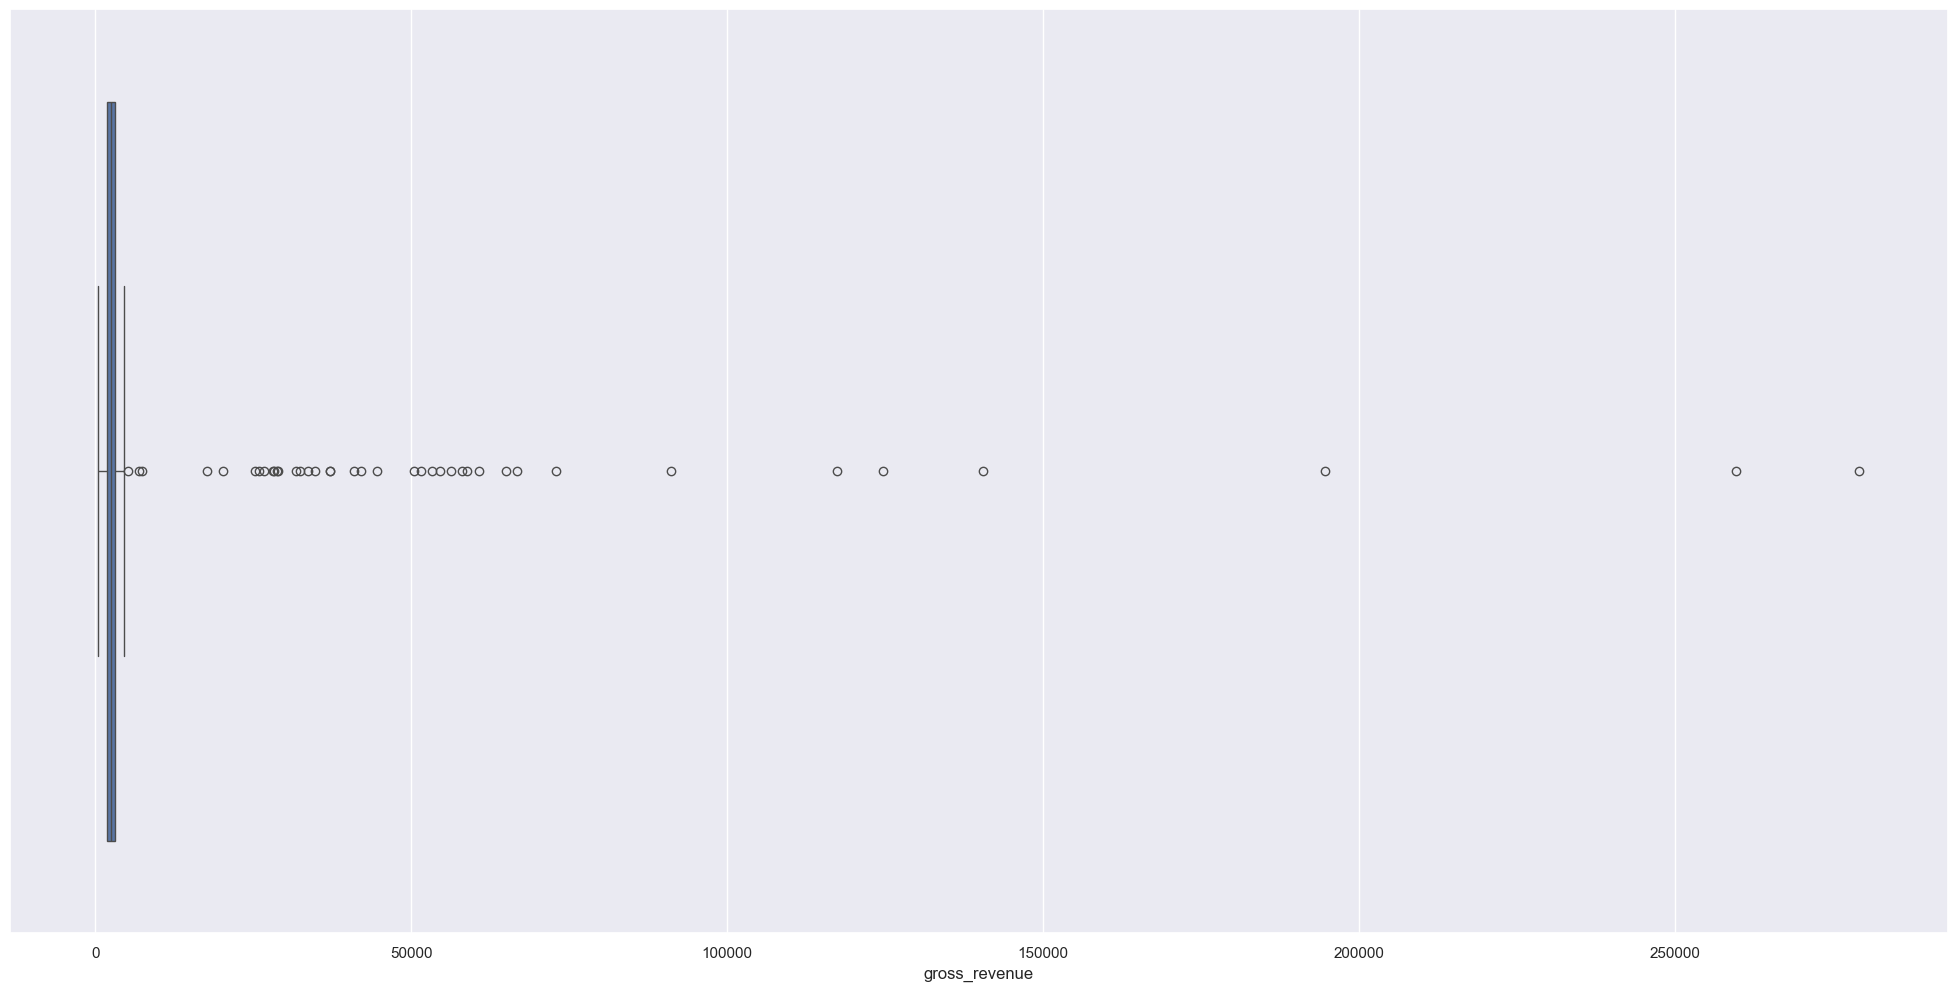

In [119]:
sns.boxplot(x = df10.loc[df10['cluster'] == 7, 'gross_revenue'])

<Axes: xlabel='gross_revenue'>

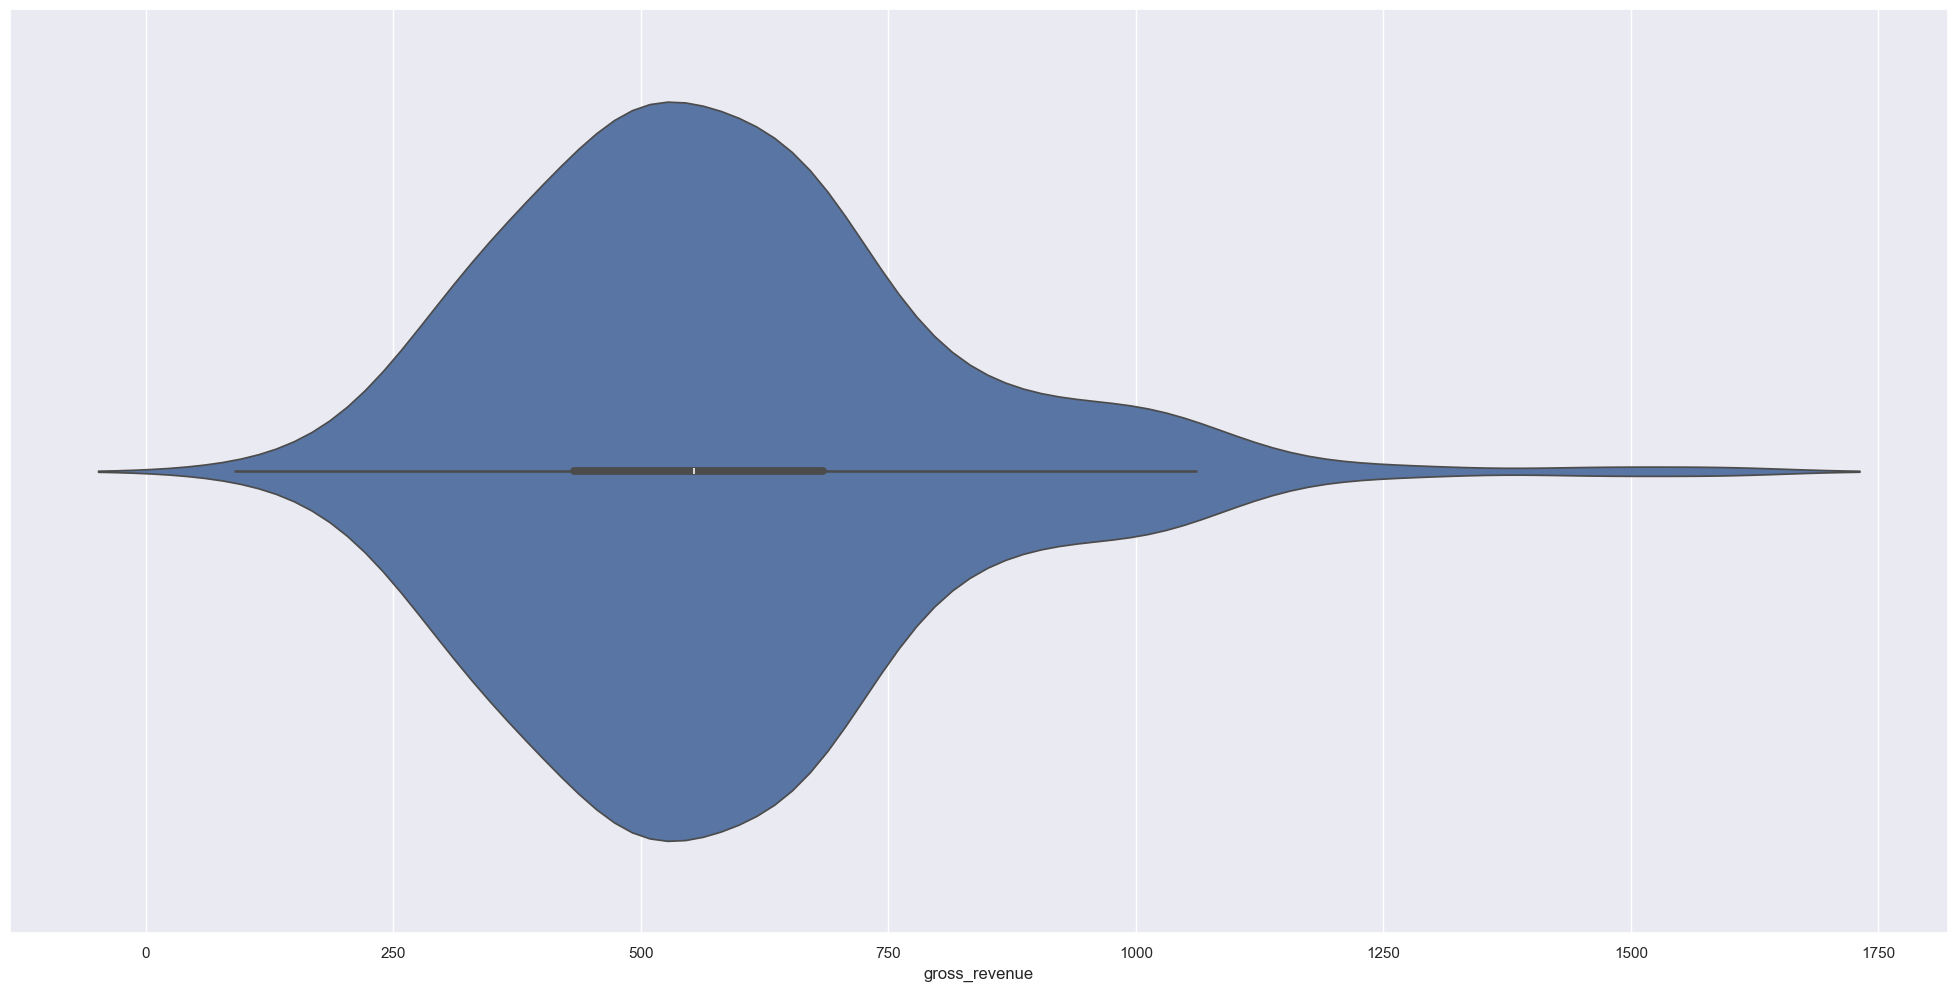

In [120]:
sns.violinplot(x = df10.loc[(df10['cluster'] == 1) & (df10['gross_revenue'] < 10000), 'gross_revenue'])

### Hipotese Cliente

1. Afirmação | Cluster | Tamanho da base (chute)
- Os clientes do cluster insiders são majoritariamente casados.
- 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
- 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
- 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
- 90% dos clientes do cluster insiders tem ensino superior completo

### Hipotese Produto

1. Afirmação | Cluster | Tamanho da base (chute)
- 30% de todos os produtos em pacotes grandes são comprados pelo clientes do cluster insiders.
- A mediana dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior que a mediana
  de todos os preços dos produtos.
- O percentil do preço dos produtos comprados pelos clientes insiders.
- O peso médio dos produtos comprados pelos clientes do cluster insiders é maior que o peso médio dos outros clusters.
- A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

### Perguntas de Negócio

In [121]:
df10.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtd_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,0
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,5


#### **1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

In [96]:
df10.loc[df10['cluster'] == 2, 'customer_id'].head()

9      16098
49     12868
105    14741
106    13715
124    14901
Name: customer_id, dtype: int64

#### **2. Quantos clientes farão parte do grupo?**

In [97]:
df10.loc[df10['cluster'] == 2, 'customer_id'].size

238

#### **3. Quais as principais características desses clientes?**

##### Cluster Insiders
- Número de customers: 242 (8.15% dos customers)
- Faturamento médio: $ 12.0015,85 dólares
- Recência média: 38 dias.
- Média de produtos comprados: 300 produtos.
- Frequencia de produtos comprados: 0.05 produtos/dia.
- Quantidade de Retornos: 202.

In [123]:
import scipy.stats as st

df_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue']

st.t.interval (confidence=0.95,
               df=len(df_insiders)-1,
               loc=np.mean(df_insiders),
               scale = st.sem(df_insiders))

(np.float64(7823.761442773292), np.float64(16207.95169772258))

#### **4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?**

In [162]:
df_insiders_gmv = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()

df_gmv_all = df10.loc[:, 'gross_revenue'].sum()

# soma da qtd de produtos total
print(' % GMV from Insiders: {:.2f} %'.format(100*(df_insiders_gmv/df_gmv_all)))

 % GMV from Insiders: 36.37 %


#### **NEXT PHASE: 5. Qual a expectativas de faturamento desse grupo para os próximos meses?**

#### **6. Quais as condições para um pessoa ser elegível ao Insiders?**

#### **7. Quais as condições para um pessoa ser removida do Insiders?**

#### **8. Qual a garantia que o programa Insiders é o melhor que o restante da base?**

#### **9. Quais ações o time de marketing pode realizar para aumentar o faturamento?**

## 10.3 Priorização das Hipóteses

## 10.4 Validação das Hipóteses

## 10.5 Quadro de Respostas

# 10.0 Deploy to Production